##### This notebook characterizes basic behavior and shared fits over all data. 

Produces visuals/analyses for figures 2-3,6-8, fig 6 - Supplement 2.

Normative evidence weighting and accumulation in correlated environments. Tardiff et al. (2024).

Nathan Tardiff
05/28/24

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import pickle
import copy
import itertools
from matplotlib import rc as rcmat
from os import path
from datetime import date
from itertools import product
from ddm import Sample
from ddm.functions import fit_adjust_model, display_model, solve_partial_conditions
import models_corr
import helpers
import gddmwrapper as gdw
import ddm_corr_subj as ddm_corr
from ddm import set_N_cpus

%config InlineBackend.figure_formats = ['svg']

In [2]:
#global style settings
rcmat('font',**{'family':'sans-serif','sans-serif':['Arial']})

plt.rcParams['font.size'] = 10.0
plt.rcParams["figure.labelsize"] = 11.0 #supxlabel/supylabel
plt.rcParams["figure.titlesize"] = 12.0 #title/suptitle
plt.rcParams['legend.fontsize'] = 8.0
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'custom' #so uses same font as normal text for math/symbols

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [3]:
set_N_cpus(4)
fit_dir = './data/fits'
fit_dir0 = path.join(fit_dir,'base0'); #fit directory for the zero corr fits to establish need for collapsing bound
fig_dir = './Manuscript/Figure set draft/figs_raw'
data_dir = './data/'
data_files = {0.2:'r02_May10_parsed_data.csv',
              0.4:'r04_Apr8_Apr11_parsed_data.csv',
              0.6:'r06_Jan11_Jan17_Apr6_parsed_data.csv',
              0.8:'r08_Apr7_parsed_data.csv'}

cmap = mpl.colormaps['RdBu'](np.linspace(0,1,20))
r_colors = dict(zip([-1.0,0.0,1.0], [cmap[0],(0.5,0.5,0.5,1.0),cmap[-1]]))

#we'll use this
idx = pd.IndexSlice
cm = 1/2.54  # centimeters in inches

In [4]:
#helper function for figure sizing
#from:https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


#plot fits for all subjects
def plot_psycho_chrono_subj(psychodf,chronodf,r_colors=r_colors,medianRT=False,mod_suffix=[''],mod_line=['-'],alpha=1,
                           RT_err=True):
    if isinstance(mod_suffix,str):
        mod_suffix = [mod_suffix]
    if isinstance(mod_line,str):
        mod_line = [mod_line]        
    multi_cond = (list(r_colors.keys())==[-1.0,0.0,1.0])
    
    for (s,d),(_,dc) in zip(psychodf.groupby('subject'),chronodf.groupby('subject')):
        fig,ax = plt.subplots(nrows=1,ncols=2+RT_err)
        d.reset_index(level='subject',drop=True,inplace=True)
        dc.reset_index(level='subject',drop=True,inplace=True)
        for (r,dd),(rr,ddc) in zip(d.groupby('rho'),dc.groupby('rho')):
            #plot psycho
            assert r==rr
            r_col = np.sign(r) if multi_cond else r
            #print(r)
            dd.index=dd.index.droplevel(['rho','mu'])
            ax[0].errorbar(dd.index,dd['response']['mean'],dd['response']['sem'],
                            marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2)
            for m,l in zip(mod_suffix,mod_line):
                ax[0].plot(dd['pred_response' + m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)

            set_size(12,4,ax[0])
            ax[0].legend()
            ax[0].set_xlabel('evidence strength')
            ax[0].set_ylabel('proportion choose right')
            ax[0].set_title(s)

            #plot chrono
            ddc.index=ddc.index.droplevel(['rho','mu'])
            chrono_corr = ddc.xs(1.0,level='correct')
            chrono_err = ddc.xs(0.0,level='correct')

            if medianRT:
                ax[1].plot(chrono_corr['RT']['median'],
                               marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12)
            else:
                ax[1].errorbar(chrono_corr.index,chrono_corr['RT']['mean'],chrono_corr['RT']['sem'],
                               marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2)
                
            for m,l in zip(mod_suffix,mod_line):
                ax[1].plot(chrono_corr['mean_RT_corr'+m]['mean'],linestyle=l,color=r_colors[r_col])
                
            set_size(12,4,ax[1])
            ax[1].set_xlabel('evidence strength')
            ax[1].set_ylabel('mean RT (sec, correct trials)')
            
            if RT_err:
                if medianRT:
                    ax[2].plot(chrono_err['RT']['median'],
                       marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12)
                else:
                    ax[2].errorbar(chrono_err.index,chrono_err['RT']['mean'],chrono_err['RT']['sem'],
                                   marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2)
                for m,l in zip(mod_suffix,mod_line):
                    ax[2].plot(chrono_err['mean_RT_err' + m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)

                ax[2].set_xlabel('evidence strength')
                ax[2].set_ylabel('mean RT (sec, error trials)')
                set_size(12,4,ax[2])
            
def plot_psycho_chrono_ave(psychodf,chronodf,r_colors=r_colors,mod_suffix=[''],mod_line=['-'],alpha=1,RT_err=True,
                           ax=None,ax_labels=True):
    if isinstance(mod_suffix,str):
        mod_suffix = [mod_suffix]
    if isinstance(mod_line,str):
        mod_line = [mod_line]        
    multi_cond = (list(r_colors.keys())==[-1.0,0.0,1.0])
    
    if ax is None:
        fig,ax = plt.subplots(nrows=1,ncols=2+RT_err)
    else:
        fig = None
                
    for (r,dd),(rr,ddc) in zip(psychodf.groupby('rho'),chronodf.groupby('rho')):
        #plot psycho
        assert r==rr
        r_col = np.sign(r) if multi_cond else r
        dd.index=dd.index.droplevel(['rho'])
        ax[0].errorbar(dd.index,dd['response']['mean'],dd['response']['sem'],
                        marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2,alpha=alpha)
        #ax[0].plot(dd.index,dd['pred_response']['mean'],linestyle='-',color=r_colors[r_col])
        for m,l in zip(mod_suffix,mod_line):
            ax[0].plot(dd['pred_response' + m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)

        set_size(12,4,ax[0])
        ax[0].legend()
        if ax_labels:
            ax[0].set_xlabel('evidence strength')
            ax[0].set_ylabel('proportion choose right')

        #plot chrono
        ddc.index=ddc.index.droplevel(['rho'])
        chrono_corr = ddc.xs(1.0,level='correct')
        chrono_err = ddc.xs(0.0,level='correct')
        
        ax[1].errorbar(chrono_corr.index,chrono_corr['RT']['mean'],chrono_corr['RT']['sem'],
                       marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2,alpha=alpha)
        
        for m,l in zip(mod_suffix,mod_line):
            ax[1].plot(chrono_corr['mean_RT_corr'+m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)
            
        set_size(12,4,ax[1])
        if ax_labels:
            ax[1].set_xlabel('evidence strength')
            ax[1].set_ylabel('mean RT (sec, correct trials)')
        
        if RT_err:
            ax[2].errorbar(chrono_err.index,chrono_err['RT']['mean'],chrono_err['RT']['sem'],
                           marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2)

            for m,l in zip(mod_suffix,mod_line):
                ax[2].plot(chrono_err['mean_RT_err' + m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)
            
            if ax_labels:
                ax[2].set_xlabel('evidence strength')
                ax[2].set_ylabel('mean RT (sec, error trials)')
            set_size(12,4,ax[2])
    
    return ax if fig is None else fig,ax

In [5]:
#define functions for averaging over correlations
def meanzr(x):
    z = x.apply(lambda i: models_corr.fisherz(i)).mean()
    return models_corr.fishezr(z)


#I think this is the proper way to do SEM, but boy is it a lot of extra effort for very little difference
def semzr(x,ret=None):
    z = x.apply(lambda i: models_corr.fisherz(i))
    zmean = z.mean()
    zsd = z.std()
    zsem = zsd/np.sqrt(len(z))

    zbounds = np.array([zmean-zsem,zmean+zsem])
    zsem_asym = np.abs(models_corr.fishezr(zbounds)-models_corr.fishezr(zmean))
    
    if ret<2:
        return zsem_asym[ret]
    else:
        return zsem_asym

#SEM
def sem_low(x):
    return semzr(x,0)
def sem_high(x):
    return semzr(x,1)

In [6]:
#read in data
data = {}
for r,f in data_files.items():
    data[r] = pd.read_csv(path.join(data_dir,f))
    data[r]['rho_cond'] = r

data = pd.concat(data.values(),ignore_index=True)

#there shouldn't be any missing data from these files but let's check
assert not data.isnull().values.any(), "Missing data detected!"
display(data.head())

#now let's clean up column names
data.rename(columns={'Unnamed: 0':'trial','r':'rho','MeanMain':'mu','participant':'subject','SNR':'SNRraw'},inplace=True)
data.drop('index',axis=1,inplace=True)

#let's fix the trial column so it is actually reflecting trial numbers reset per subject
data['trial'] = np.int32(data.groupby('subject')['trial'].rank())
display(data.head())

subj = data[['subject','rho_cond']].drop_duplicates().sort_values('subject')
subj.reset_index(inplace=True,drop=True)
display(subj)
print(len(subj))
print(subj.rho_cond.value_counts())
assert not subj.subject.duplicated().any()

,Unnamed: 0,index,participant,r,MeanMain,RT,response,correct,SNR,threshold,rho_cond
0,0,5993,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2
1,1,6004,5f3ee36d0306de1a411882a5,-0.2,-0.04224,2.0112,0.0,1.0,-0.892109,0.356901,0.2
2,2,6017,5f3ee36d0306de1a411882a5,0.0,-0.01889,2.4702,0.0,1.0,-0.142733,0.356901,0.2
3,3,6030,5f3ee36d0306de1a411882a5,0.0,0.01889,2.4292,1.0,1.0,0.142733,0.356901,0.2
4,4,6048,5f3ee36d0306de1a411882a5,0.2,-0.02069,3.5572,0.0,1.0,-0.142692,0.356901,0.2


,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2
1,2,5f3ee36d0306de1a411882a5,-0.2,-0.04224,2.0112,0.0,1.0,-0.892109,0.356901,0.2
2,3,5f3ee36d0306de1a411882a5,0.0,-0.01889,2.4702,0.0,1.0,-0.142733,0.356901,0.2
3,4,5f3ee36d0306de1a411882a5,0.0,0.01889,2.4292,1.0,1.0,0.142733,0.356901,0.2
4,5,5f3ee36d0306de1a411882a5,0.2,-0.02069,3.5572,0.0,1.0,-0.142692,0.356901,0.2


,subject,rho_cond
0,575f387c91f8b40006c332e1,0.4
1,58f82417edbd82000169bce8,0.8
2,5b232f6838fc0c000131438c,0.6
3,5b3455bf532e3d00018e6e8b,0.8
4,5b477fdb56e0140001ac7720,0.8
...,...,...
95,61636a4bf1a773cc305502e7,0.6
96,616e401a1a88b28ca7581bb6,0.2
97,616f469494656434f5b4ebc6,0.2
98,6172eebe85de20b0b268d5c5,0.4


100
0.4    25
0.8    25
0.6    25
0.2    25
Name: rho_cond, dtype: int64


In [7]:
#SNR cleanup
subj_SNR_raw=data[['subject','rho','SNRraw']].drop_duplicates().sort_values(['subject','rho','SNRraw'])
assert ((subj_SNR_raw.reset_index().groupby(['subject','rho'])['SNRraw'].transform(lambda x: len(x))==4).all()), \
    'Too many SNRs detected for some subjects!'
subj_SNR_raw['rSNR']=subj_SNR_raw.groupby(['subject','rho']).rank()
#display(subj_SNR_raw.iloc[0:20])

#since there is floating-point slop between rho conds that is not fully alleviated by rounding, 
#we'll average over all rho conds to get a master set of SNR values
subj_SNR_raw=subj_SNR_raw.merge(subj_SNR_raw.groupby(['subject','rSNR'])[['SNRraw']].mean().round(2).rename({'SNRraw':'SNR'},axis=1),
                        on=['subject','rSNR']).sort_values(['subject','rho','SNR']).copy()

display(subj_SNR_raw.iloc[0:17])

#merge SNR back into data
print(data.shape)
data = data.merge(subj_SNR_raw.drop('rSNR',axis=1),on=['subject','rho','SNRraw'],how='left')
print(data.shape)
display(data)
assert (data.SNR-data.SNRraw < .006).all(), "rounded SNRs not properly joined to data!"

,subject,rho,SNRraw,rSNR,SNR
0,575f387c91f8b40006c332e1,-0.4,-0.748167,1.0,-0.75
3,575f387c91f8b40006c332e1,-0.4,-0.119707,2.0,-0.12
6,575f387c91f8b40006c332e1,-0.4,0.119707,3.0,0.12
9,575f387c91f8b40006c332e1,-0.4,0.748167,4.0,0.75
1,575f387c91f8b40006c332e1,0.0,-0.748225,1.0,-0.75
4,575f387c91f8b40006c332e1,0.0,-0.119716,2.0,-0.12
7,575f387c91f8b40006c332e1,0.0,0.119716,3.0,0.12
10,575f387c91f8b40006c332e1,0.0,0.748225,4.0,0.75
2,575f387c91f8b40006c332e1,0.4,-0.748398,1.0,-0.75
5,575f387c91f8b40006c332e1,0.4,-0.119720,2.0,-0.12


(76757, 10)
(76757, 11)


,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,SNR
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,0.14
1,2,5f3ee36d0306de1a411882a5,-0.2,-0.04224,2.0112,0.0,1.0,-0.892109,0.356901,0.2,-0.89
2,3,5f3ee36d0306de1a411882a5,0.0,-0.01889,2.4702,0.0,1.0,-0.142733,0.356901,0.2,-0.14
3,4,5f3ee36d0306de1a411882a5,0.0,0.01889,2.4292,1.0,1.0,0.142733,0.356901,0.2,0.14
4,5,5f3ee36d0306de1a411882a5,0.2,-0.02069,3.5572,0.0,1.0,-0.142692,0.356901,0.2,-0.14
...,...,...,...,...,...,...,...,...,...,...,...
76752,764,5e95d4f551598d01d6d455af,-0.8,-0.00788,3.7340,0.0,1.0,-0.124189,0.310849,0.8,-0.12
76753,765,5e95d4f551598d01d6d455af,0.8,0.05914,1.1230,1.0,1.0,0.777231,0.310849,0.8,0.78
76754,766,5e95d4f551598d01d6d455af,-0.8,0.00788,4.8250,0.0,0.0,0.124189,0.310849,0.8,0.12
76755,767,5e95d4f551598d01d6d455af,0.8,-0.05914,0.4020,0.0,1.0,-0.777231,0.310849,0.8,-0.78


In [8]:
#create SNR key by dropping duplicates
subj_SNR = subj_SNR_raw.drop(['rho','SNRraw'],axis=1).drop_duplicates()
#display(subj_SNR)

#add a universal SNR for aggregate data
subj_SNR=subj_SNR.merge(subj_SNR.groupby('rSNR').mean().rename({'SNR':'uSNR'},axis=1),
                        on='rSNR').sort_values(['subject','uSNR']).copy()

#gut checks
assert (subj_SNR.value_counts().groupby('subject').sum()==4).all(), "Incorrect number of SNRs per subject!"
assert len(subj_SNR['subject'].drop_duplicates()) == len(subj), \
    "Subject mismatch between data and subj_SNR!"
assert np.array_equal(subj_SNR.loc[subj_SNR.rSNR==1,'SNR'].abs().values,subj_SNR.loc[subj_SNR.rSNR==4,'SNR'].values) and \
    np.array_equal(subj_SNR.loc[subj_SNR.rSNR==2,'SNR'].abs().values,subj_SNR.loc[subj_SNR.rSNR==3,'SNR'].values), \
    'Inconsistent SNRs between sources!'

#set index
subj_SNR.set_index(['subject','SNR'],inplace=True)
display(subj_SNR)

/var/folders/3_/40m5_51d419__yjj36qs3p_m0001g2/T/ipykernel_8157/754919430.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subj_SNR=subj_SNR.merge(subj_SNR.groupby('rSNR').mean().rename({'SNR':'uSNR'},axis=1),


rSNR    uSNR
subject                  SNR                
575f387c91f8b40006c332e1 -0.75   1.0 -0.9239
                         -0.12   2.0 -0.1480
                          0.12   3.0  0.1480
                          0.75   4.0  0.9239
58f82417edbd82000169bce8 -0.72   1.0 -0.9239
...                              ...     ...
6172eebe85de20b0b268d5c5  0.75   4.0  0.9239
6176846e673909995a32dce3 -0.83   1.0 -0.9239
                         -0.13   2.0 -0.1480
                          0.13   3.0  0.1480
                          0.83   4.0  0.9239

[400 rows x 2 columns]

## Basic behavior

In [9]:
#trim data!
RTminmax = [0.3,15]
datat = data.loc[(data.RT >= RTminmax[0]) & (data.RT <= RTminmax[1])]
(len(data)-len(datat))/len(data) #percent of data trimmed is very small

0.008324973618041352

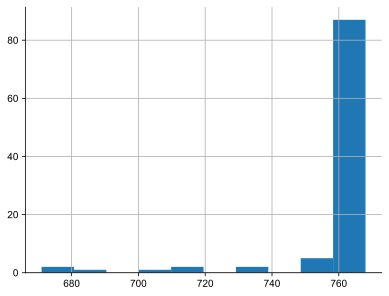

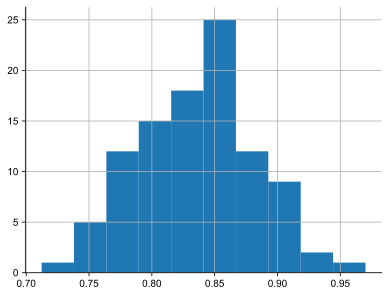

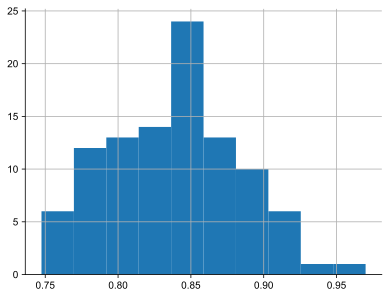

In [10]:
#general stats on amount of data per subject and subject performance
#display(data.subject.value_counts())
datat.subject.value_counts().hist()
plt.show()
data.groupby('subject').correct.mean().hist()
plt.show()
datat.groupby('subject').correct.mean().hist()
plt.show()

In [11]:
#define rho conditions for getting fits/samples later

rho_conds = datat.rho_cond.unique()
rho_conds_filestring = {r:str(r).replace('.','') for r in rho_conds}
rho_signs = np.array([-1.0,0.0,1.0])

In [12]:
#output full data for other processing
if False:
    datat_out = datat.join(subj_SNR[['uSNR']],on=['subject','SNR'])
    assert datat_out.loc[:,'trial':'SNR'].equals(datat), "Problem with joining uSNR to data!"
    assert not datat_out['uSNR'].isna().any(), "Problem with joining uSNR to data: missing uSNR values!"
    datat_out.to_csv(path.join(data_dir,'all_parsed_data_%s.csv' % date.today()),index=False)

### plot basic behavioral fig

In [13]:
datat_psycho_ave = \
    datat[['subject','rho','SNR','mu','response']].groupby(['subject','rho','SNR','mu']).agg(['mean','std','sem'])
display(datat_psycho_ave.groupby('rho').head())

datat_chrono_ave = \
    datat[['subject','rho','SNR','mu','correct','RT']].groupby(['subject','rho','SNR','mu','correct']).agg(['mean','std','sem'])
display(datat_chrono_ave.groupby('rho').head())

response                    
                                                  mean       std       sem
subject                  rho  SNR   mu                                    
575f387c91f8b40006c332e1 -0.4 -0.75 -0.03350  0.109375  0.314576  0.039322
                              -0.12 -0.01340  0.359375  0.483610  0.060451
                               0.12  0.01340  0.703125  0.460493  0.057562
                               0.75  0.03350  0.984375  0.125000  0.015625
                          0.0 -0.75 -0.04325  0.109375  0.314576  0.039322
                              -0.12 -0.01730  0.406250  0.495015  0.061877
                               0.12  0.01730  0.906250  0.293785  0.036723
                               0.75  0.04325  0.968750  0.175368  0.021921
                          0.4 -0.75 -0.05118  0.093750  0.293785  0.036723
                              -0.12 -0.02047  0.281250  0.453163  0.056645
                               0.12  0.02047  0.843750  0.365963  0.045745
                               0.75  0.05118  0.953125  0.213042  0.026630
58f82417edbd82000169bce8 -0.8 -0.72 -0.01897  0.066667  0.251549  0.032475
                              -0.12 -0.00759  0.403226  0.494550  0.062808
                               0.12  0.00759  0.796875  0.405505  0.050688
                               0.72  0.01897  0.951613  0.216335  0.027475
                          0.0 -0.72 -0.04241  0.015625  0.125000  0.015625
                          0.8 -0.72 -0.05690  0.063492  0.245805  0.030968
                              -0.12 -0.02276  0.317460  0.469227  0.059117
                               0.12  0.02276  0.777778  0.419079  0.052799
                               0.72  0.05690  0.967742  0.178127  0.022622
5b232f6838fc0c000131438c -0.6 -0.89 -0.02987  0.078125  0.270490  0.033811
                              -0.14 -0.01195  0.406250  0.495015  0.061877
                               0.14  0.01195  0.796875  0.405505  0.050688
                               0.89  0.02987  0.953125  0.213042  0.026630
                          0.6 -0.89 -0.05974  0.046875  0.213042  0.026630
                              -0.14 -0.02390  0.296875  0.460493  0.057562
                               0.14  0.02390  0.812500  0.393398  0.049175
                               0.89  0.05974  1.000000  0.000000  0.000000
5b3455bf532e3d00018e6e8b -0.8 -0.66 -0.01819  0.187500  0.393398  0.049175
                          0.8 -0.66 -0.05458  0.140625  0.350382  0.043798
5b5ca33f295c4b0001c294d0 -0.4 -0.81 -0.03477  0.000000  0.000000  0.000000
                          0.4 -0.81 -0.05311  0.015625  0.125000  0.015625
5b8c8e7d0c740e00019d55c3 -0.6 -0.86 -0.02938  0.062500  0.243975  0.030497
                          0.6 -0.86 -0.05877  0.031250  0.175368  0.021921
5bd781291fd7c80001bb1fad -0.2 -0.81 -0.04015  0.062500  0.243975  0.030497
                              -0.13 -0.01606  0.281250  0.453163  0.056645
                               0.13  0.01606  0.734375  0.445157  0.055645
                               0.81  0.04015  0.984375  0.125000  0.015625
                          0.2 -0.81 -0.04917  0.046875  0.213042  0.026630
                              -0.13 -0.01967  0.187500  0.393398  0.049175
                               0.13  0.01967  0.734375  0.445157  0.055645
                               0.81  0.04917  0.968750  0.175368  0.021921
5d645bf6912c630018e269e3 -0.2 -1.04 -0.04552  0.171875  0.380254  0.047532
                          0.2 -1.04 -0.05575  0.171875  0.380254  0.047532

RT            \
                                                          mean       std   
subject                  rho  SNR   mu       correct                       
575f387c91f8b40006c332e1 -0.4 -0.75 -0.03350 0.0      3.605714  1.856701   
                                             1.0      2.734781  0.882488   
                              -0.12 -0.01340 0.0      3.086874  1.135117   
                                             1.0      2.946388  1.004948   
                               0.12  0.01340 0.0      2.496626  0.843780   
                          0.0 -0.75 -0.04325 0.0      2.002286  0.751804   
                                             1.0      2.570647  0.907455   
                              -0.12 -0.01730 0.0      2.922254  1.086153   
                                             1.0      2.827755  1.218041   
                               0.12  0.01730 0.0      3.486450  1.120658   
                          0.4 -0.75 -0.05118 0.0      2.415867  1.289492   
                                             1.0      2.459212  0.947419   
                              -0.12 -0.02047 0.0      2.560089  1.108950   
                                             1.0      2.841450  1.080723   
                               0.12  0.02047 0.0      2.639440  0.818084   
58f82417edbd82000169bce8 -0.8 -0.72 -0.01897 0.0      3.699500  1.988548   
                                             1.0      2.911679  1.699150   
                              -0.12 -0.00759 0.0      3.611480  1.743437   
                                             1.0      3.066297  1.279710   
                               0.12  0.00759 0.0      3.047923  0.833213   
                          0.8 -0.72 -0.05690 0.0      2.891750  1.169060   
                                             1.0      2.568153  1.000523   
                              -0.12 -0.02276 0.0      3.183400  1.449378   
                                             1.0      2.955535  1.149211   
                               0.12  0.02276 0.0      2.760357  1.794017   
5b232f6838fc0c000131438c -0.6 -0.89 -0.02987 0.0      4.957400  2.912065   
                                             1.0      2.915008  1.176968   
                              -0.14 -0.01195 0.0      3.624435  2.355111   
                                             1.0      3.045018  1.676974   
                               0.14  0.01195 0.0      2.876669  1.571359   
                          0.6 -0.89 -0.05974 0.0      1.477633  0.249984   
                                             1.0      2.724497  1.460335   
                              -0.14 -0.02390 0.0      3.673842  2.460267   
                                             1.0      3.078538  2.174258   
                               0.14  0.02390 0.0      3.566825  2.188608   
5bd781291fd7c80001bb1fad -0.2 -0.81 -0.04015 0.0      2.806550  1.100412   
                                             1.0      1.994917  0.671982   
                              -0.13 -0.01606 0.0      2.689339  0.793360   
                                             1.0      2.041659  0.551630   
                               0.13  0.01606 0.0      2.491012  0.884248   
                          0.2 -0.81 -0.04917 0.0      2.370533  0.696690   
                                             1.0      1.967684  0.674544   
                              -0.13 -0.01967 0.0      2.643167  0.740102   
                                             1.0      2.101046  0.610086   
                               0.13  0.01967 0.0      2.224988  0.505722   

                                                                
                                                           sem  
subject                  rho  SNR   mu       correct            
575f387c91f8b40006c332e1 -0.4 -0.75 -0.03350 0.0      0.701767  
                                             1.0      0.116888  
                              -0.12 -0.01340 0.0      0.236688  
                     

In [14]:
#now create RT normed by rho==0.0 RT (averaged across all data per subj, separate for correct/error)

datat_r0_SNR_chrono_ave = \
    datat.loc[datat.rho==0.0,['subject','correct','SNR','RT']].groupby(['subject','correct','SNR']).agg(['mean'])
display(datat_r0_SNR_chrono_ave.head())
datat_r0_chrono_ave = datat_r0_SNR_chrono_ave.xs('mean',axis=1,level=1).groupby(['subject','correct']).agg(['mean'])
display(datat_r0_chrono_ave.head())

RT_norm = datat_chrono_ave[[('RT','mean')]] - datat_r0_chrono_ave[[('RT','mean')]]
datat_chrono_ave= datat_chrono_ave.join(RT_norm,rsuffix='_norm0')
display(datat_chrono_ave.head())

RT
                                            mean
subject                  correct SNR            
575f387c91f8b40006c332e1 0.0     -0.75  2.002286
                                 -0.12  2.922254
                                  0.12  3.486450
                                  0.75  2.731550
                         1.0     -0.75  2.570647

RT
                                      mean
subject                  correct          
575f387c91f8b40006c332e1 0.0      2.785635
                         1.0      2.650590
58f82417edbd82000169bce8 0.0      2.449071
                         1.0      2.791224
5b232f6838fc0c000131438c 0.0      3.230544

RT            \
                                                         mean       std   
subject                  rho  SNR   mu      correct                       
575f387c91f8b40006c332e1 -0.4 -0.75 -0.0335 0.0      3.605714  1.856701   
                                            1.0      2.734781  0.882488   
                              -0.12 -0.0134 0.0      3.086874  1.135117   
                                            1.0      2.946388  1.004948   
                               0.12  0.0134 0.0      2.496626  0.843780   

                                                               RT_norm0  
                                                          sem      mean  
subject                  rho  SNR   mu      correct                      
575f387c91f8b40006c332e1 -0.4 -0.75 -0.0335 0.0      0.701767  0.820079  
                                            1.0      0.116888  0.084191  
                              -0.12 -0.0134 0.0      0.236688  0.301239  
                                            1.0      0.156947  0.295798  
                               0.12  0.0134 0.0      0.193576 -0.289009

In [15]:
datat_psycho_ave_all = \
    datat_psycho_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['rho','uSNR']).agg(['mean','std','sem'])
display(datat_psycho_ave_all)

datat_chrono_ave_all = \
    datat_chrono_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['rho','uSNR','correct']).agg(['mean','std','sem'])
display(datat_chrono_ave_all)

response                     rSNR          
                  mean       std       sem mean  std  sem
rho  uSNR                                                
-0.8 -0.9239  0.095098  0.061610  0.012322  1.0  0.0  0.0
     -0.1480  0.289612  0.111452  0.022290  2.0  0.0  0.0
      0.1480  0.711479  0.089335  0.017867  3.0  0.0  0.0
      0.9239  0.924907  0.051747  0.010349  4.0  0.0  0.0
-0.6 -0.9239  0.081639  0.052622  0.010524  1.0  0.0  0.0
     -0.1480  0.283473  0.090698  0.018140  2.0  0.0  0.0
      0.1480  0.752392  0.071163  0.014233  3.0  0.0  0.0
      0.9239  0.916485  0.047024  0.009405  4.0  0.0  0.0
-0.4 -0.9239  0.053611  0.047643  0.009529  1.0  0.0  0.0
     -0.1480  0.227794  0.122965  0.024593  2.0  0.0  0.0
      0.1480  0.769287  0.090160  0.018032  3.0  0.0  0.0
      0.9239  0.941389  0.043959  0.008792  4.0  0.0  0.0
-0.2 -0.9239  0.085252  0.050260  0.010052  1.0  0.0  0.0
     -0.1480  0.283214  0.081900  0.016380  2.0  0.0  0.0
      0.1480  0.739003  0.074175  0.014835  3.0  0.0  0.0
      0.9239  0.917261  0.059933  0.011987  4.0  0.0  0.0
 0.0 -0.9239  0.075545  0.056731  0.005673  1.0  0.0  0.0
     -0.1480  0.267933  0.096548  0.009655  2.0  0.0  0.0
      0.1480  0.772412  0.080849  0.008085  3.0  0.0  0.0
      0.9239  0.932959  0.053089  0.005309  4.0  0.0  0.0
 0.2 -0.9239  0.085672  0.057869  0.011574  1.0  0.0  0.0
     -0.1480  0.277182  0.071597  0.014319  2.0  0.0  0.0
      0.1480  0.759754  0.074592  0.014918  3.0  0.0  0.0
      0.9239  0.919718  0.039722  0.007944  4.0  0.0  0.0
 0.4 -0.9239  0.066985  0.050029  0.010006  1.0  0.0  0.0
     -0.1480  0.232314  0.107188  0.021438  2.0  0.0  0.0
      0.1480  0.773078  0.093741  0.018748  3.0  0.0  0.0
      0.9239  0.950303  0.038987  0.007797  4.0  0.0  0.0
 0.6 -0.9239  0.065321  0.041583  0.008317  1.0  0.0  0.0
     -0.1480  0.261880  0.091798  0.018360  2.0  0.0  0.0
      0.1480  0.758433  0.077942  0.015588  3.0  0.0  0.0
      0.9239  0.947710  0.043345  0.008669  4.0  0.0  0.0
 0.8 -0.9239  0.060619  0.041266  0.008253  1.0  0.0  0.0
     -0.1480  0.257721  0.087919  0.017584  2.0  0.0  0.0
      0.1480  0.785974  0.073793  0.014759  3.0  0.0  0.0
      0.9239  0.951316  0.037494  0.007499  4.0  0.0  0.0

RT                      RT_norm0            \
                          mean       std       sem      mean       std   
rho  uSNR    correct                                                     
-0.8 -0.9239 0.0      3.255500  1.792148  0.358430  0.805786  1.504709   
             1.0      2.903680  0.843171  0.168634  0.470057  0.369767   
     -0.1480 0.0      3.839407  1.417452  0.283490  1.389693  0.988517   
             1.0      3.445038  1.091729  0.218346  1.011416  0.544051   
      0.1480 0.0      3.371822  1.332527  0.266505  0.922108  0.918590   
...                        ...       ...       ...       ...       ...   
 0.8 -0.1480 1.0      2.481942  0.802311  0.160462  0.048319  0.287145   
      0.1480 0.0      2.530168  1.059625  0.211925  0.080455  0.687738   
             1.0      2.428839  0.887333  0.177467 -0.004784  0.279658   
      0.9239 0.0      2.120885  1.752033  0.365324 -0.231899  1.684788   
             1.0      1.915635  0.510659  0.102132 -0.517987  0.338379   

                               rSNR            
                           sem mean  std  sem  
rho  uSNR    correct                           
-0.8 -0.9239 0.0      0.300942  1.0  0.0  0.0  
             1.0      0.073953  1.0  0.0  0.0  
     -0.1480 0.0      0.197703  2.0  0.0  0.0  
             1.0      0.108810  2.0  0.0  0.0  
      0.1480 0.0      0.183718  3.0  0.0  0.0  
...                        ...  ...  ...  ...  
 0.8 -0.1480 1.0      0.057429  2.0  0.0  0.0  
      0.1480 0.0      0.137548  3.0  0.0  0.0  
             1.0      0.055932  3.0  0.0  0.0  
      0.9239 0.0      0.351303  4.0  0.0  0.0  
             1.0      0.067676  4.0  0.0  0.0  

[72 rows x 9 columns]

In [16]:
cmap_stacked = mpl.colormaps['RdBu'](np.linspace(0,1,9))
cmap_stacked[4] = [0.5,0.5,0.5,1.0]
rhos = datat_psycho_ave_all.index.get_level_values('rho').sort_values().unique().to_numpy()

r_colors_stacked = dict(zip(rhos, cmap_stacked))

### paper plot

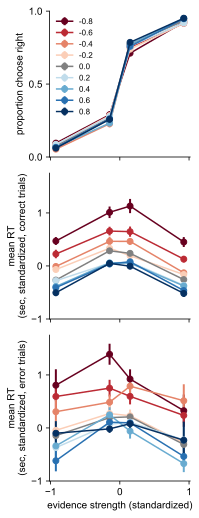

In [17]:
#first plot basic behavioral fits stacked, RT normalized version, vertical version
cm = 1/2.54  # centimeters in inches
plot_err = True

fig,ax = plt.subplots(nrows=2+plot_err,ncols=1)
for (r,dd),(rr,ddc) in zip(datat_psycho_ave_all.groupby('rho'),datat_chrono_ave_all.groupby('rho')):
        #plot psycho
        assert r==rr
        dd.index=dd.index.droplevel(['rho'])
        ax[0].errorbar(dd.index,dd['response']['mean'],dd['response']['sem'],
                        marker='.',linestyle='-',color=r_colors_stacked[r],label=r,markersize=12,elinewidth=2,alpha=1)


        #plot chrono
        ddc.index=ddc.index.droplevel(['rho'])
        chrono_corr = ddc.xs(1.0,level='correct')
        
        ax[1].errorbar(chrono_corr.index,chrono_corr['RT_norm0']['mean'],chrono_corr['RT_norm0']['sem'],
                       marker='.',linestyle='-',color=r_colors_stacked[r],label=r,markersize=12,elinewidth=2,alpha=1)
        
        if plot_err:
            chrono_err = ddc.xs(0.0,level='correct')
        
            ax[2].errorbar(chrono_err.index,chrono_err['RT_norm0']['mean'],chrono_err['RT_norm0']['sem'],
                       marker='.',linestyle='-',color=r_colors_stacked[r],label=r,markersize=12,elinewidth=2,alpha=1)
            
        
#set_size(plt_size[0],plt_size[1],ax[0])
ax[0].legend(frameon=False,loc='upper left')
#ax[0].set_xlabel('SNR (normalized)')
ax[0].set_xticks((-1.0,0.0,1.0))
ax[0].set_xticklabels(())
ax[0].set_yticks((0,0.5,1))
ax[0].set_ylim((0,1))
ax[0].set_ylabel('proportion choose right')

#set_size(plt_size[0],plt_size[1],ax[1])
if not plot_err:
    ax[1].set_xlabel('evidence strength (standardized)')
ax[1].set_xticks((-1.0,0.0,1.0))
ax[1].set_xticklabels(())
ax[1].set_ylim((-1,1.75))
ax[1].locator_params(nbins=3, axis='y')
ax[1].set_ylabel('mean RT\n(sec, standardized, correct trials)');

if plot_err:
    #set_size(plt_size[0],plt_size[1],ax[2])
    ax[2].set_xlabel('evidence strength (standardized)')
    ax[2].set_xticks((-1.0,0.0,1.0))
    ax[2].set_ylim((-1,1.75))
    ax[2].locator_params(nbins=3, axis='y')
    ax[2].set_ylabel('mean RT\n(sec, standardized, error trials)');
    

fig.set_figwidth(7.25*cm)
fig.set_figheight(18.5*cm)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig3_all_%s.pdf' % date.today()))

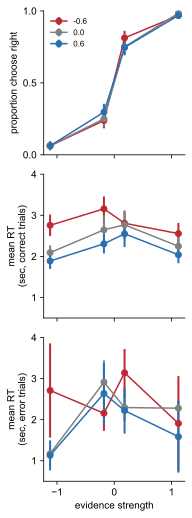

In [18]:
#plot example subject, vertical
ex_subj = '615b4d67bd21e66571f5581b'


#first plot basic behavioral fits stacked, RT normalized version
cm = 1/2.54  # centimeters in inches
plot_err = True

fig,ax = plt.subplots(nrows=2+plot_err,ncols=1)
for (r,dd),(rr,ddc) in zip(datat_psycho_ave.loc[ex_subj].groupby('rho'),
                           datat_chrono_ave.loc[ex_subj].groupby('rho')):
        #plot psycho
        assert r==rr
        dd.index=dd.index.droplevel(['rho'])
        ax[0].errorbar(dd.index.get_level_values('SNR'),dd['response']['mean'],dd['response']['sem'],
                        marker='.',linestyle='-',color=r_colors_stacked[r],label=r,markersize=12,elinewidth=2,alpha=1)


        #plot chrono
        ddc.index=ddc.index.droplevel(['rho'])
        chrono_corr = ddc.xs(1.0,level='correct')
        
        ax[1].errorbar(chrono_corr.index.get_level_values('SNR'),chrono_corr['RT']['mean'],chrono_corr['RT']['sem'],
                       marker='.',linestyle='-',color=r_colors_stacked[r],label=r,markersize=12,elinewidth=2,alpha=1)
        
        if plot_err:
            chrono_err = ddc.xs(0.0,level='correct')
        
            ax[2].errorbar(chrono_err.index.get_level_values('SNR'),chrono_err['RT']['mean'],chrono_err['RT']['sem'],
                       marker='.',linestyle='-',color=r_colors_stacked[r],label=r,markersize=12,elinewidth=2,alpha=1)
            
        
ax[0].legend(frameon=False)
#ax[0].set_xlabel('SNR')
ax[0].set_xticks((-1.0,0.0,1.0))
ax[0].set_xticklabels(())
ax[0].set_yticks((0,0.5,1))
ax[0].set_ylim((0,1))
ax[0].set_ylabel('proportion choose right')

if not plot_err:
    ax[1].set_xlabel('evidence strength')
ax[1].set_xticks((-1.0,0.0,1.0))
ax[1].set_xticklabels(())
ax[1].set_ylim((0.5,4))
ax[1].locator_params(nbins=6, axis='y')
ax[1].set_ylabel('mean RT\n(sec, correct trials)');

if plot_err:
    ax[2].set_xlabel('evidence strength')
    ax[2].set_xticks((-1.0,0.0,1.0))
    ax[2].set_ylim((0.5,4))
    ax[2].locator_params(nbins=6, axis='y')
    ax[2].set_ylabel('mean RT\n(sec, error trials)');
    

fig.set_figwidth(7.0*cm)
fig.set_figheight(18.5*cm)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig3_exsubj_%s.pdf' % date.today()))

# schematics 
Schematics for figures.

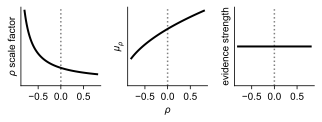

In [19]:
#schematic for showing how mean changes while rho stays fixed

mu_0 = 0.5
corr_smooth = np.linspace(-0.8,0.8,100)
mu_corr = mu_0*np.sqrt(1+corr_smooth)
rho_corr = 1/(1+corr_smooth)
SNR_basic = (mu_corr**2)*rho_corr #ignores some scale factor due to sd, etc

fig,ax=plt.subplots(nrows=1,ncols=3)
ax[0].axhline(0,linestyle=':',color='k',alpha=0.0)
ax[0].axvline(0,linestyle=':',color='k',alpha=0.5)
ax[0].plot(corr_smooth,rho_corr,color='k',linewidth=2)
ax[0].set_yticks([])
ax[0].set_ylabel(r'$\rho$ scale factor')


ax[1].axhline(0,linestyle=':',color='k',alpha=0.0)
ax[1].axvline(0,linestyle=':',color='k',alpha=0.5)
ax[1].plot(corr_smooth,mu_corr,color='k',linewidth=2)
ax[1].set_yticks([])
ax[1].set_ylabel(r'$\mu_{\rho}$')
ax[1].set_xlabel(r'$\rho$')


ax[2].axvline(0,linestyle=':',color='k',alpha=0.5)
ax[2].plot(corr_smooth,SNR_basic,color='k',linewidth=2)
ax[2].set_yticks([])
ax[2].set_ylabel('evidence strength')


fig.set_figheight(4.6*cm)
fig.set_figwidth(11.75*cm)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig2_scaling_%s.pdf' % date.today()))

[0.06070308 0.09598    0.12140616]
[0.17888544 0.28284271 0.35777088]


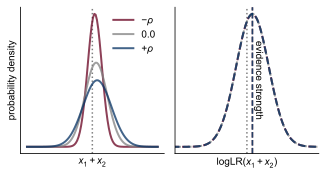

In [20]:
#analytic distributions for generative distributions and LLR, using sum distribution 
cm = 1/2.54

cmap = mpl.colormaps['RdBu'](np.linspace(0,1,20))
r_colors = dict(zip([-1.0,0.0,1.0], [cmap[0],(0.5,0.5,0.5,1.0),cmap[-1]]))

gen_spec=pd.Series({'mu':0.04799,'sd':0.2})
r_analytic = np.array([-0.6,0.0,0.6])
mu_analytic = gen_spec.mu*np.sqrt(1+r_analytic)

mu_sumdist = 2*mu_analytic #mean for sum distribution
sd_sumdist = np.sqrt(2*(1+r_analytic))*gen_spec.sd #sd for sum distribution version of generative dist
print(mu_sumdist)
print(sd_sumdist)

xrange = np.linspace(st.norm.ppf(0.05),
                st.norm.ppf(1.0-0.05), 100)
   
    
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].axvline(0,linestyle=':',color='k',alpha=0.5)
schem_lines = []
for m,s,r in zip(mu_sumdist,sd_sumdist,r_analytic):
    liner, = ax[0].plot(xrange,st.norm.pdf(xrange,loc=m,scale=s),linewidth=2,alpha=0.75,color=r_colors[np.sign(r)])
    schem_lines.append(liner)

ax[0].set_yticks([])
ax[0].set_ylabel('probability density')
ax[0].set_xticks([])
ax[0].set_xlabel(r'$x_1+x_2$');
ax[0].legend(handles=schem_lines,labels=(r'$\minus$$\rho$','0.0',r'+$\rho$'),
             frameon=False,fontsize=10)

ax[1].axvline(0,linestyle=':',color='k',alpha=0.5)
for m,s,r in zip(mu_sumdist,sd_sumdist,r_analytic):
    LLRi_scale = m/(s**2/2)
    LLR_sampi = LLRi_scale*st.norm.rvs(loc=m,scale=s,size=100000)
    ax[1].plot(xrange*LLRi_scale,st.norm.pdf(xrange*LLRi_scale,loc=m*LLRi_scale,scale=s*LLRi_scale),
               color=r_colors[np.sign(r)],alpha=0.75,linewidth=2,linestyle='--')
    snr_line=ax[1].axvline(LLRi_scale*m,linestyle='--',color=r_colors[np.sign(r)],alpha=0.75,linewidth=1.5)
    

ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_xlabel(r'logLR($x_1+x_2$)');
ax[1].set_xlim([-3,3])

ax[1].annotate('evidence strength', (0.5, 0.5), xytext=(1.5,0), xycoords=snr_line, 
               va='center',rotation=-90, textcoords="offset points")


fig.set_figheight(6.5*cm)
fig.set_figwidth(11.75*cm)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig2_pdf_%s.pdf' % date.today()))

# Fits

## Load/assess joint (shared) fits

Here we will load and analyze all models that fit all correlation conditions in a correlation group jointly, where differences between the models are in whether parameters are shared between or vary across the correlation conditions.

In [21]:
shared_mods = ['rsharedCLT','bound_rscaleCLT_sk','bound_sharedCLT_vk','bound_rscaleCLT_vk']

In [22]:
shared_samps = {}
for rc in rho_conds:
    shared_samps[rc],_ = \
        gdw.load_data(datat.loc[(datat.rho_cond==rc)].copy(),
                      rt="RT",conds=['rho','mu'],verbose=False,debug=False)
        
#quick and dirty gut check
assert np.all(np.array([len(x) for x in shared_samps.values()])==25), "Incorrect number of subjects per corr!"

In [23]:
#get fit for all models
shared_fits = {}
for rc in rho_conds:
    shared_fits[rc] = {}
    for m in shared_mods:
        shared_fits[rc][m] = \
            gdw.load_models(path.join(fit_dir,'%s_*_r%s_*_2023-??-??' % (m,rho_conds_filestring[rc])),
                            verbose=False)
        shared_fits[rc][m] = {f.subject:f for f in shared_fits[rc][m]}
        
print(np.array([len(x) for x in shared_fits.values()]))
print(np.array([len(y) for x in shared_fits.values() for y in x.values()]))

[4 4 4 4]
[25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25]


In [24]:
#let's actually get params first so we can check on boundary issues before going to the trouble of solving

params_shared = []
for rc,fdict in shared_fits.items():
    print(rc)
    for m,fits in fdict.items():
        print(m)
        #print(fits)
        if len(fits) > 0:
            parami = ddm_corr.get_all_params(fits)
            parami['rho_cond'] = rc
            parami['model'] = m
            params_shared.append(parami)
    
params_shared = pd.concat(params_shared)
params_shared.set_index(['rho_cond','model','subject'],inplace=True,append=True)
params_shared = params_shared.reorder_levels(['rho_cond','model','subject','param']).sort_index()

0.2
rsharedCLT
                  value hit_boundary                   subject
param                                                         
driftSNR0     12.538418        False  5f30ee4c383a0d56521f69c7
B0             1.536982        False  5f30ee4c383a0d56521f69c7
t              0.000000         True  5f30ee4c383a0d56521f69c7
nondectime     0.242746        False  5f30ee4c383a0d56521f69c7
umixturecoef   0.021150        False  5f30ee4c383a0d56521f69c7
                 value hit_boundary                   subject
param                                                        
t             0.000000         True  5f30ee4c383a0d56521f69c7
umixturecoef  0.001000         True  613a8ef513f5e9934f6f6fb3
umixturecoef  0.002081         True  613433e6d6d82dbdad53e847
t             0.037866         True  5f74fa0614255d15319ee076
t             0.036171         True  61267b828ead584bcf092e35
umixturecoef  0.001000         True  61267b828ead584bcf092e35
t             0.025179         True  616f4694946

In [25]:
#some sanity checks
assert np.all(params_shared.xs('t',level='param').groupby(['model','rho_cond']).size().to_numpy()==25), \
    "Wrong number of subjects per model in params"
assert len(params_shared.xs('t',level='param').groupby(['model','rho_cond']).size())==len(rho_conds)*len(shared_mods), \
    "Wrong number of model/rho cond combinations in params"

#first pass check for any problematic fits re: param bounds
display(params_shared.loc[params_shared.hit_boundary].groupby('param').hit_boundary.value_counts())
display(params_shared.loc[params_shared.hit_boundary].groupby('param').min())
display(params_shared.loc[params_shared.hit_boundary].groupby('param').max())

param         hit_boundary
nondectime    True             11
t             True            109
umixturecoef  True            108
Name: hit_boundary, dtype: int64

,value,hit_boundary
param,,
nondectime,0.00125,True
t,0.00000,True
umixturecoef,0.00100,True


,value,hit_boundary
param,,
nondectime,0.029559,True
t,0.059972,True
umixturecoef,0.003937,True


In [26]:
#now let's get predictions
do_sols = False
if do_sols:
    shared_soldf = {k:{} for k in shared_mods}
    for (sk,sv),(mk,mv) in zip(shared_samps.items(),shared_fits.items()):
        assert sk==mk
        print(sk)
        #print(sv)
        #shared_soldf[sk] = {}
        for mvn,mvi in mv.items():
            print(mvn)
            soldf = ddm_corr.get_all_sols(sv,mvi)
            #soldf = {}
            soldf['rho_cond'] = sk
            soldf['model'] = mvn
            #print(soldf)
            
            shared_soldf[mvn][sk] = soldf
            
    with open(path.join(fit_dir,'shared_sols_%s' % date.today()),'wb') as f:
        pickle.dump(shared_soldf,f)
else:
    with open(path.join(fit_dir,'shared_sols_2023-06-25'),'rb') as f:
        shared_soldf = pickle.load(f)

#These are probably overkill and some guaranteed to pass, but better safe than sorry...   
assert len(shared_soldf)==len(shared_mods), "Not all model sols present!"
assert np.all(np.array([len(f.keys()) for f in shared_soldf.values()])==len(rho_conds)), "Not all rho_conds present for all model types!"
assert np.all(np.array([len(y.subject.unique()) for x in shared_soldf.values() for y in x.values()])==25), 'Incorrect number of subjects in solutions'
assert np.all(np.array([y.groupby('subject').size().unique() for x in shared_soldf.values() for y in x.values()])==12), 'Incorrect number of solutions per subject'

shared_soldf = {k:pd.concat(v,ignore_index=True).set_index(['subject','rho_cond']) for k,v in shared_soldf.items()}
shared_soldf

{'rsharedCLT':                                    rho       mu  mean_corr  mean_err  \
 subject                  rho_cond                                      
 5f30ee4c383a0d56521f69c7 0.2       0.0 -0.02818   0.743425  0.256575   
                          0.2       0.2 -0.03088   0.725520  0.274480   
                          0.2       0.2 -0.07719   0.914546  0.085454   
                          0.2      -0.2  0.06302   0.945030  0.054970   
                          0.2      -0.2 -0.02521   0.765987  0.234013   
 ...                                ...      ...        ...       ...   
 6010b797bbe6be440425665c 0.8       0.0  0.02092   0.750795  0.249205   
                          0.8       0.0 -0.05229   0.915680  0.084320   
                          0.8       0.0 -0.02092   0.750795  0.249205   
                          0.8      -0.8 -0.02339   0.941259  0.058741   
                          0.8       0.8  0.02806   0.712447  0.287553   
 
                                   

In [27]:
for df in shared_soldf.values():
    assert (df.groupby('subject').count()==12).all().all(), 'Incorrect number of conditions detected in solution!'

In [28]:
#combine predictions w/ data
datat_mshared_dict = {m:ddm_corr.data_pred_merge(datat,sols,on=['subject','rho_cond','rho','mu']) 
                 for m,sols in shared_soldf.items()}

   trial                   subject  rho       mu      RT  response  correct  \
0      1  5f3ee36d0306de1a411882a5  0.2  0.02069  1.6825       1.0      1.0   
1     18  5f3ee36d0306de1a411882a5  0.2  0.02069  2.9287       1.0      1.0   
2     36  5f3ee36d0306de1a411882a5  0.2  0.02069  2.6330       0.0      0.0   
3     40  5f3ee36d0306de1a411882a5  0.2  0.02069  2.6890       1.0      1.0   
4     59  5f3ee36d0306de1a411882a5  0.2  0.02069  1.7222       0.0      0.0   

     SNRraw  threshold  rho_cond   SNR  mean_corr  mean_err  mean_RT_corr  \
0  0.142692   0.356901       0.2  0.14   0.709801  0.290199       2.44972   
1  0.142692   0.356901       0.2  0.14   0.709801  0.290199       2.44972   
2  0.142692   0.356901       0.2  0.14   0.709801  0.290199       2.44972   
3  0.142692   0.356901       0.2  0.14   0.709801  0.290199       2.44972   
4  0.142692   0.356901       0.2  0.14   0.709801  0.290199       2.44972   

   mean_RT_err       model  pred_response  
0     2.645194  rs

In [29]:
#bind all predictions into one df...awk...

mod_cols = ['pred_response','mean_RT_corr','mean_RT_err']


datat_mshared = datat_mshared_dict[shared_mods[0]].drop(['mean_corr','mean_err','model'],axis=1).merge(datat_mshared_dict[shared_mods[1]][['rho_cond','subject','trial','pred_response','mean_RT_corr','mean_RT_err']],
                                                         on=['rho_cond','subject','trial'],
                                                        suffixes=('_'+x for x in shared_mods[0:2]),
                                                          validate='1:1')
for m in shared_mods[2:]:
    datat_mshared = datat_mshared.merge(datat_mshared_dict[m][['rho_cond','subject','trial','pred_response','mean_RT_corr','mean_RT_err']],
                                                         on=['rho_cond','subject','trial'],
                                                          validate='1:1')
    datat_mshared.rename(dict(zip(mod_cols,[x + '_' + m for x in mod_cols])),axis=1,inplace=True)
    
datat_mshared.head()

,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,...,pred_response_rsharedCLT,pred_response_bound_rscaleCLT_sk,mean_RT_corr_bound_rscaleCLT_sk,mean_RT_err_bound_rscaleCLT_sk,pred_response_bound_sharedCLT_vk,mean_RT_corr_bound_sharedCLT_vk,mean_RT_err_bound_sharedCLT_vk,pred_response_bound_rscaleCLT_vk,mean_RT_corr_bound_rscaleCLT_vk,mean_RT_err_bound_rscaleCLT_vk
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,...,0.709801,0.697648,2.577134,2.768835,0.706345,2.443509,2.657084,0.739975,2.55722,2.803025
1,18,5f3ee36d0306de1a411882a5,0.2,0.02069,2.9287,1.0,1.0,0.142692,0.356901,0.2,...,0.709801,0.697648,2.577134,2.768835,0.706345,2.443509,2.657084,0.739975,2.55722,2.803025
2,36,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6330,0.0,0.0,0.142692,0.356901,0.2,...,0.709801,0.697648,2.577134,2.768835,0.706345,2.443509,2.657084,0.739975,2.55722,2.803025
3,40,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6890,1.0,1.0,0.142692,0.356901,0.2,...,0.709801,0.697648,2.577134,2.768835,0.706345,2.443509,2.657084,0.739975,2.55722,2.803025
4,59,5f3ee36d0306de1a411882a5,0.2,0.02069,1.7222,0.0,0.0,0.142692,0.356901,0.2,...,0.709801,0.697648,2.577134,2.768835,0.706345,2.443509,2.657084,0.739975,2.55722,2.803025


In [30]:
#save out for learning effect analysis (Josh)
if False:
    mshared_out_cols = ['trial', 'subject', 'rho', 'mu', 'RT', 'response', 'correct', 'SNRraw',
       'threshold', 'rho_cond', 'SNR', 
       'pred_response_bound_rscaleCLT_sk', 'mean_RT_corr_bound_rscaleCLT_sk',
       'mean_RT_err_bound_rscaleCLT_sk', 'pred_response_bound_rscaleCLT_vk', 'mean_RT_corr_bound_rscaleCLT_vk',
       'mean_RT_err_bound_rscaleCLT_vk']
    datat_mshared_out = datat_mshared[mshared_out_cols].copy()
    
    #so as not to cause confusion, nan out RTs from opposite correctness
    datat_mshared_out.loc[datat_mshared_out.correct==0,'mean_RT_corr_bound_rscaleCLT_sk'] = np.nan
    datat_mshared_out.loc[datat_mshared_out.correct==0,'mean_RT_corr_bound_rscaleCLT_vk'] = np.nan
    datat_mshared_out.loc[datat_mshared_out.correct==1,'mean_RT_err_bound_rscaleCLT_sk'] = np.nan
    datat_mshared_out.loc[datat_mshared_out.correct==1,'mean_RT_err_bound_rscaleCLT_vk'] = np.nan
    
    #assign the best fitting model for each rho cond to be its predicted value
    datat_mshared_out['mean_RT_corr_best'] = datat_mshared_out.apply(lambda x: x['mean_RT_corr_bound_rscaleCLT_sk'] \
                        if (x['rho_cond'] < 0.5) else x['mean_RT_corr_bound_rscaleCLT_vk'],axis=1)
    assert datat_mshared_out.loc[datat_mshared_out.rho_cond<0.5,'mean_RT_corr_bound_rscaleCLT_sk'].equals(\
        datat_mshared_out.loc[datat_mshared_out.rho_cond<0.5,'mean_RT_corr_best'])
    assert datat_mshared_out.loc[datat_mshared_out.rho_cond>0.5,'mean_RT_corr_bound_rscaleCLT_vk'].equals(\
        datat_mshared_out.loc[datat_mshared_out.rho_cond>0.5,'mean_RT_corr_best'])
    
    datat_mshared_out['mean_RT_err_best'] = datat_mshared_out.apply(lambda x: x['mean_RT_err_bound_rscaleCLT_sk'] \
                    if (x['rho_cond'] < 0.5) else x['mean_RT_err_bound_rscaleCLT_vk'],axis=1)
    assert datat_mshared_out.loc[datat_mshared_out.rho_cond<0.5,'mean_RT_err_bound_rscaleCLT_sk'].equals(\
        datat_mshared_out.loc[datat_mshared_out.rho_cond<0.5,'mean_RT_err_best'])
    assert datat_mshared_out.loc[datat_mshared_out.rho_cond>0.5,'mean_RT_err_bound_rscaleCLT_vk'].equals(\
        datat_mshared_out.loc[datat_mshared_out.rho_cond>0.5,'mean_RT_err_best'])
    
    datat_mshared_out['pred_response_best'] = datat_mshared_out.apply(lambda x: x['pred_response_bound_rscaleCLT_sk'] \
                        if (x['rho_cond'] < 0.5) else x['pred_response_bound_rscaleCLT_vk'],axis=1)
    assert datat_mshared_out.loc[datat_mshared_out.rho_cond<0.5,'pred_response_bound_rscaleCLT_sk'].equals(\
        datat_mshared_out.loc[datat_mshared_out.rho_cond<0.5,'pred_response_best'])
    assert datat_mshared_out.loc[datat_mshared_out.rho_cond>0.5,'pred_response_bound_rscaleCLT_vk'].equals(\
        datat_mshared_out.loc[datat_mshared_out.rho_cond>0.5,'pred_response_best'])
    
    
    display(datat_mshared_out.head())
    
    datat_mshared_out.to_csv(path.join(data_dir,'data_best_model_%s.csv' % date.today()),index=False)

In [31]:
#compute columns for best-fitting model (based on fit stats). 
#Redundant w/ _out above but not adding in the nans

datat_mshared['mean_RT_corr_best'] = datat_mshared.apply(lambda x: x['mean_RT_corr_bound_rscaleCLT_sk'] \
                    if (x['rho_cond'] < 0.5) else x['mean_RT_corr_bound_rscaleCLT_vk'],axis=1)
assert datat_mshared.loc[datat_mshared.rho_cond<0.5,'mean_RT_corr_bound_rscaleCLT_sk'].equals(\
    datat_mshared.loc[datat_mshared.rho_cond<0.5,'mean_RT_corr_best'])
assert datat_mshared.loc[datat_mshared.rho_cond>0.5,'mean_RT_corr_bound_rscaleCLT_vk'].equals(\
    datat_mshared.loc[datat_mshared.rho_cond>0.5,'mean_RT_corr_best'])

datat_mshared['mean_RT_err_best'] = datat_mshared.apply(lambda x: x['mean_RT_err_bound_rscaleCLT_sk'] \
                    if (x['rho_cond'] < 0.5) else x['mean_RT_err_bound_rscaleCLT_vk'],axis=1)
assert datat_mshared.loc[datat_mshared.rho_cond<0.5,'mean_RT_err_bound_rscaleCLT_sk'].equals(\
    datat_mshared.loc[datat_mshared.rho_cond<0.5,'mean_RT_err_best'])
assert datat_mshared.loc[datat_mshared.rho_cond>0.5,'mean_RT_err_bound_rscaleCLT_vk'].equals(\
    datat_mshared.loc[datat_mshared.rho_cond>0.5,'mean_RT_err_best'])

datat_mshared['pred_response_best'] = datat_mshared.apply(lambda x: x['pred_response_bound_rscaleCLT_sk'] \
                    if (x['rho_cond'] < 0.5) else x['pred_response_bound_rscaleCLT_vk'],axis=1)
assert datat_mshared.loc[datat_mshared.rho_cond<0.5,'pred_response_bound_rscaleCLT_sk'].equals(\
    datat_mshared.loc[datat_mshared.rho_cond<0.5,'pred_response_best'])
assert datat_mshared.loc[datat_mshared.rho_cond>0.5,'pred_response_bound_rscaleCLT_vk'].equals(\
    datat_mshared.loc[datat_mshared.rho_cond>0.5,'pred_response_best'])
display(datat_mshared.head())

,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,...,mean_RT_err_bound_rscaleCLT_sk,pred_response_bound_sharedCLT_vk,mean_RT_corr_bound_sharedCLT_vk,mean_RT_err_bound_sharedCLT_vk,pred_response_bound_rscaleCLT_vk,mean_RT_corr_bound_rscaleCLT_vk,mean_RT_err_bound_rscaleCLT_vk,mean_RT_corr_best,mean_RT_err_best,pred_response_best
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,...,2.768835,0.706345,2.443509,2.657084,0.739975,2.55722,2.803025,2.577134,2.768835,0.697648
1,18,5f3ee36d0306de1a411882a5,0.2,0.02069,2.9287,1.0,1.0,0.142692,0.356901,0.2,...,2.768835,0.706345,2.443509,2.657084,0.739975,2.55722,2.803025,2.577134,2.768835,0.697648
2,36,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6330,0.0,0.0,0.142692,0.356901,0.2,...,2.768835,0.706345,2.443509,2.657084,0.739975,2.55722,2.803025,2.577134,2.768835,0.697648
3,40,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6890,1.0,1.0,0.142692,0.356901,0.2,...,2.768835,0.706345,2.443509,2.657084,0.739975,2.55722,2.803025,2.577134,2.768835,0.697648
4,59,5f3ee36d0306de1a411882a5,0.2,0.02069,1.7222,0.0,0.0,0.142692,0.356901,0.2,...,2.768835,0.706345,2.443509,2.657084,0.739975,2.55722,2.803025,2.577134,2.768835,0.697648


In [32]:
mod_cols_resp = ['_'.join(x) for x in product(['pred_response'],shared_mods+['best'])]
mod_cols_RT = ['_'.join(x) for x in product(['mean_RT_corr','mean_RT_err'],shared_mods+['best'])]
mod_cols_suffix = ['_'+x for x in shared_mods]
mod_lines = [':','-',(0,(1,10)),(0,(5,10))]

datat_mshared_psycho_ave = \
    datat_mshared[['subject','rho_cond','rho','SNR','mu','response']+mod_cols_resp].groupby(['subject','rho_cond','rho','SNR','mu']).agg(['mean','std','sem'])
display(datat_mshared_psycho_ave.groupby('rho_cond').head())

datat_mshared_chrono_ave = \
    datat_mshared[['subject','rho_cond','rho','SNR','mu','correct','RT']+mod_cols_RT].groupby(['subject','rho_cond','rho','SNR','mu','correct']).agg(['mean','std','sem'])
display(datat_mshared_chrono_ave.groupby('rho_cond').head())

response            \
                                                           mean       std   
subject                  rho_cond rho  SNR   mu                             
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350  0.109375  0.314576   
                                       -0.12 -0.01340  0.359375  0.483610   
                                        0.12  0.01340  0.703125  0.460493   
                                        0.75  0.03350  0.984375  0.125000   
                                   0.0 -0.75 -0.04325  0.109375  0.314576   
58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897  0.066667  0.251549   
                                       -0.12 -0.00759  0.403226  0.494550   
                                        0.12  0.00759  0.796875  0.405505   
                                        0.72  0.01897  0.951613  0.216335   
                                   0.0 -0.72 -0.04241  0.015625  0.125000   
5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987  0.078125  0.270490   
                                       -0.14 -0.01195  0.406250  0.495015   
                                        0.14  0.01195  0.796875  0.405505   
                                        0.89  0.02987  0.953125  0.213042   
                                   0.0 -0.89 -0.04723  0.234375  0.426956   
5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015  0.062500  0.243975   
                                       -0.13 -0.01606  0.281250  0.453163   
                                        0.13  0.01606  0.734375  0.445157   
                                        0.81  0.04015  0.984375  0.125000   
                                   0.0 -0.81 -0.04489  0.031250  0.175368   

                                                                 \
                                                            sem   
subject                  rho_cond rho  SNR   mu                   
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350  0.039322   
                                       -0.12 -0.01340  0.060451   
                                        0.12  0.01340  0.057562   
                                        0.75  0.03350  0.015625   
                                   0.0 -0.75 -0.04325  0.039322   
58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897  0.032475   
                                       -0.12 -0.00759  0.062808   
                                        0.12  0.00759  0.050688   
                                        0.72  0.01897  0.027475   
                                   0.0 -0.72 -0.04241  0.015625   
5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987  0.033811   
                                       -0.14 -0.01195  0.061877   
                                        0.14  0.01195  0.050688   
                                        0.89  0.02987  0.026630   
                                   0.0 -0.89 -0.04723  0.053370   
5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015  0.030497   
                                       -0.13 -0.01606  0.056645   
                                        0.13  0.01606  0.055645   
                                        0.81  0.04015  0.015625   
                                   0.0 -0.81 -0.04489  0.021921   

                                                      pred_response_rsharedCLT  \
                                                                          mean   
subject                  rho_cond rho  SNR   mu                                  
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350                 0.064406   
                                       -0.12 -0.01340                 0.269672   
                                        0.12  0.01340                 0.730328   
                                        0.75  0.03350                 0.935594   
                                   0.0 -0.75 -0.04325                 0.083952   
58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897                 0.109609   
   

RT  \
                                                                   mean   
subject                  rho_cond rho  SNR   mu       correct             
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      3.605714   
                                                      1.0      2.734781   
                                       -0.12 -0.01340 0.0      3.086874   
                                                      1.0      2.946388   
                                        0.12  0.01340 0.0      2.496626   
58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897 0.0      3.699500   
                                                      1.0      2.911679   
                                       -0.12 -0.00759 0.0      3.611480   
                                                      1.0      3.066297   
                                        0.12  0.00759 0.0      3.047923   
5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987 0.0      4.957400   
                                                      1.0      2.915008   
                                       -0.14 -0.01195 0.0      3.624435   
                                                      1.0      3.045018   
                                        0.14  0.01195 0.0      2.876669   
5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015 0.0      2.806550   
                                                      1.0      1.994917   
                                       -0.13 -0.01606 0.0      2.689339   
                                                      1.0      2.041659   
                                        0.13  0.01606 0.0      2.491012   

                                                                         \
                                                                    std   
subject                  rho_cond rho  SNR   mu       correct             
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      1.856701   
                                                      1.0      0.882488   
                                       -0.12 -0.01340 0.0      1.135117   
                                                      1.0      1.004948   
                                        0.12  0.01340 0.0      0.843780   
58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897 0.0      1.988548   
                                                      1.0      1.699150   
                                       -0.12 -0.00759 0.0      1.743437   
                                                      1.0      1.279710   
                                        0.12  0.00759 0.0      0.833213   
5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987 0.0      2.912065   
                                                      1.0      1.176968   
                                       -0.14 -0.01195 0.0      2.355111   
                                                      1.0      1.676974   
                                        0.14  0.01195 0.0      1.571359   
5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015 0.0      1.100412   
                                                      1.0      0.671982   
                                       -0.13 -0.01606 0.0      0.793360   
                                                      1.0      0.551630   
                                        0.13  0.01606 0.0      0.884248   

                                                                         \
                                                                    sem   
subject                  rho_cond rho  SNR   mu       correct             
575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      0.701767   
                                                      1.0      0.116888   
                                       -0.12 -0.01340 0.0      0.236688   
                                                      1.0      0.156947   
                                        0.12  0.01340 0.0      0.193576   
58f82417edbd82000

In [33]:
#average over subjects

datat_mshared_psycho_ave_all = \
    datat_mshared_psycho_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['rho_cond','rho','uSNR']).agg(['mean','std','sem'])
display(datat_mshared_psycho_ave_all)

datat_mshared_chrono_ave_all = \
    datat_mshared_chrono_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['rho_cond','rho','uSNR','correct']).agg(['mean','std','sem'])
display(datat_mshared_chrono_ave_all)

response                     pred_response_rsharedCLT  \
                           mean       std       sem                     mean   
rho_cond rho  uSNR                                                             
0.2      -0.2 -0.9239  0.085252  0.050260  0.010052                 0.078142   
              -0.1480  0.283214  0.081900  0.016380                 0.266350   
               0.1480  0.739003  0.074175  0.014835                 0.733650   
               0.9239  0.917261  0.059933  0.011987                 0.921858   
          0.0 -0.9239  0.096458  0.069155  0.013831                 0.093167   
              -0.1480  0.285612  0.080750  0.016150                 0.281887   
               0.1480  0.750764  0.076671  0.015334                 0.718113   
               0.9239  0.909801  0.057619  0.011524                 0.906833   
          0.2 -0.9239  0.085672  0.057869  0.011574                 0.106720   
              -0.1480  0.277182  0.071597  0.014319                 0.294547   
               0.1480  0.759754  0.074592  0.014918                 0.705453   
               0.9239  0.919718  0.039722  0.007944                 0.893280   
0.4      -0.4 -0.9239  0.053611  0.047643  0.009529                 0.043007   
              -0.1480  0.227794  0.122965  0.024593                 0.217773   
               0.1480  0.769287  0.090160  0.018032                 0.782227   
               0.9239  0.941389  0.043959  0.008792                 0.956993   
          0.0 -0.9239  0.070111  0.049615  0.009923                 0.068655   
              -0.1480  0.254194  0.123503  0.024701                 0.253933   
               0.1480  0.797621  0.096876  0.019375                 0.746067   
               0.9239  0.952090  0.038988  0.007798                 0.931345   
          0.4 -0.9239  0.066985  0.050029  0.010006                 0.090886   
              -0.1480  0.232314  0.107188  0.021438                 0.278318   
               0.1480  0.773078  0.093741  0.018748                 0.721682   
               0.9239  0.950303  0.038987  0.007797                 0.909114   
0.6      -0.6 -0.9239  0.081639  0.052622  0.010524                 0.054113   
              -0.1480  0.283473  0.090698  0.018140                 0.217783   
               0.1480  0.752392  0.071163  0.014233                 0.782217   
               0.9239  0.916485  0.047024  0.009405                 0.945887   
          0.0 -0.9239  0.068428  0.055101  0.011020                 0.096884   
              -0.1480  0.269174  0.082990  0.016598                 0.279219   
               0.1480  0.774248  0.073194  0.014639                 0.720781   
               0.9239  0.928411  0.055768  0.011154                 0.903116   
          0.6 -0.9239  0.065321  0.041583  0.008317                 0.130496   
              -0.1480  0.261880  0.091798  0.018360                 0.311380   
               0.1480  0.758433  0.077942  0.015588                 0.688620   
               0.9239  0.947710  0.043345  0.008669                 0.869504   
0.8      -0.8 -0.9239  0.095098  0.061610  0.012322                 0.075962   
              -0.1480  0.289612  0.111452  0.022290                 0.217643   
               0.1480  0.711479  0.089335  0.017867                 0.782357   
               0.9239  0.924907  0.051747  0.010349                 0.924038   
          0.0 -0.9239  0.067183  0.048822  0.009764                 0.122744   
              -0.1480  0.262752  0.096119  0.019224                 0.292205   
               0.1480  0.767015  0.071822  0.014364                 0.707795   
               0.9239  0.941534  0.051364  0.010273                 0.877256   
          0.8 -0.9239  0.060619  0.041266  0.008253                 0.157857   
              -0.1480  0.257721  0.087919  0.017584                 0.325682   
               0.1480  0.785974  0.073793  0.014759                 0.674318   
               0.9239  

RT                      \
                                   mean       std       sem   
rho_cond rho  uSNR    correct                                 
0.2      -0.2 -0.9239 0.0      2.412258  0.966600  0.193320   
                      1.0      2.281203  0.750839  0.150168   
              -0.1480 0.0      2.728609  1.194281  0.238856   
                      1.0      2.682526  1.103623  0.220725   
               0.1480 0.0      2.687307  1.121576  0.224315   
...                                 ...       ...       ...   
0.8       0.8 -0.1480 1.0      2.481942  0.802311  0.160462   
               0.1480 0.0      2.530168  1.059625  0.211925   
                      1.0      2.428839  0.887333  0.177467   
               0.9239 0.0      2.120885  1.752033  0.365324   
                      1.0      1.915635  0.510659  0.102132   

                              mean_RT_corr_rsharedCLT                      \
                                                 mean       std       sem   
rho_cond rho  uSNR    correct                                               
0.2      -0.2 -0.9239 0.0                    2.283302  0.699257  0.139851   
                      1.0                    2.283302  0.699257  0.139851   
              -0.1480 0.0                    2.926392  1.060449  0.212090   
                      1.0                    2.926392  1.060449  0.212090   
               0.1480 0.0                    2.926392  1.060449  0.212090   
...                                               ...       ...       ...   
0.8       0.8 -0.1480 1.0                    2.154805  0.558406  0.111681   
               0.1480 0.0                    2.154805  0.558406  0.111681   
                      1.0                    2.154805  0.558406  0.111681   
               0.9239 0.0                    1.772270  0.415698  0.086679   
                      1.0                    1.821060  0.432373  0.086475   

                              mean_RT_corr_bound_rscaleCLT_sk            \
                                                         mean       std   
rho_cond rho  uSNR    correct                                             
0.2      -0.2 -0.9239 0.0                            2.124713  0.651810   
                      1.0                            2.124713  0.651810   
              -0.1480 0.0                            2.683087  0.974882   
                      1.0                            2.683087  0.974882   
               0.1480 0.0                            2.683087  0.974882   
...                                                       ...       ...   
0.8       0.8 -0.1480 1.0                            2.453635  0.788387   
               0.1480 0.0                            2.453635  0.788387   
                      1.0                            2.453635  0.788387   
               0.9239 0.0                            1.888875  0.490920   
                      1.0                            1.953076  0.522973   

                                        mean_RT_corr_bound_sharedCLT_vk  ...  \
                                    sem                            mean  ...   
rho_cond rho  uSNR    correct                                            ...   
0.2      -0.2 -0.9239 0.0      0.130362                        2.249623  ...   
                      1.0      0.130362                        2.249623  ...   
              -0.1480 0.0      0.194976                        2.910693  ...   
                      1.0      0.194976                        2.910693  ...   
               0.1480 0.0      0.194976                        2.910693  ...   
...                                 ...                             ...  ...   
0.8       0.8 -0.1480 1.0      0.157677                        2.251913  ...   
               0.1480 0.0      0.157677                        2.251913  ...   
                      1.0      0.157677                        2.251913  ...   
               0.9239 0.0      0.102364                        1

### paper plots

/var/folders/3_/40m5_51d419__yjj36qs3p_m0001g2/T/ipykernel_8157/1223666448.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


7.086614173228346
4.133858267716535


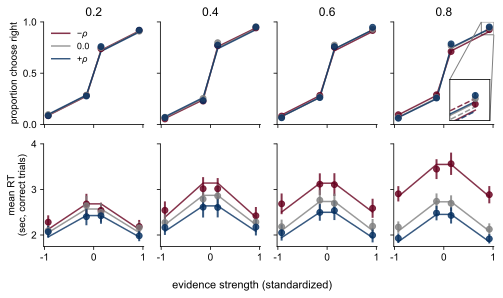

In [34]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

#horizontal version. 
cm = 1/2.54  # centimeters in inches
fig,ax=plt.subplots(nrows=2,ncols=4,sharex=True)
#then plot best fit model only against data separately per corr cond
for axi,(rcp,dfp_r),(rcc,dfc_r) in zip(ax.T,datat_mshared_psycho_ave_all.groupby('rho_cond'),
                               datat_mshared_chrono_ave_all.groupby('rho_cond')):
    assert rcp==rcc
    #print(rcp)
    dfp_r.reset_index(level='rho_cond',drop=True,inplace=True)
    dfc_r.reset_index(level='rho_cond',drop=True,inplace=True)
    plot_psycho_chrono_ave(dfp_r,dfc_r,mod_suffix='_best',
                                   alpha=0.8,RT_err=False,ax=axi,ax_labels=False)
    
    axi[0].set_ylim((0,1))
    axi[0].set_xticks([-1.0,0.0,1.0]) #this is redundant b/c sharex is on, but leaving
    axi[0].set_xticklabels([])
    axi[0].set_yticks([0,0.5,1])
    axi[0].set_title(rcp)
    if rcp==0.2:
        axi[0].legend(labels=(r'$\minus$$\rho$','0.0',r'+$\rho$'),
                      frameon=False,fontsize=9)
    else:
        axi[0].legend().set_visible(False)
    #axi[1].set_yticks([2,3])
    axi[1].set_xticks([-1.0,0.0,1.0])
    axi[1].set_xticklabels([-1,0,1])
    
    axi[1].locator_params(nbins=3, axis='y')
    axi[1].set_ylim((1.75,4))
    
    if rcp > 0.2:
        axi[0].set_yticklabels([])
        axi[1].set_yticklabels([])
    

    #create inset for 0.8. We want to show the importance of the drift parameter for getting the ordering right
    if rcp==0.8:
        axins = [inset_axes(x, width="40%", height="40%", loc=4) for x in axi]

        plot_psycho_chrono_ave(dfp_r,dfc_r,mod_suffix=['_bound_rscaleCLT_vk','_bound_rscaleCLT_sk'],
                               mod_line=['-','--'],
                               alpha=0.8,RT_err=False,ax=axins,ax_labels=False)
        
        axins[0].legend().set_visible(False)
        scale_axin = 0.125

        for axii,axini in zip(axi,axins):
            axi_xlim = axii.get_xlim()
            axi_ylim = axii.get_ylim()
            axin_xlim0 = axi_xlim[1] - scale_axin*(axi_xlim[1]-axi_xlim[0])
            axin_ylim0 = axi_ylim[1] - scale_axin*(axi_ylim[1]-axi_ylim[0])
            
            axini.set_xticks([])
            axini.set_yticks([])
            axini.spines['top'].set_visible(True)
            axini.spines['right'].set_visible(True)
            axini.set_xlim([axin_xlim0,axi_xlim[1]])
            axini.set_ylim([axin_ylim0,axi_ylim[1]])
        mark_inset(axi[0], axins[0], loc1=2, loc2=4, fc="none", ec="0.5")
        axins[1].remove()
    
fig.supxlabel('evidence strength (standardized)')
ax[0,0].set_ylabel('proportion choose right')
ax[1,0].set_ylabel('mean RT\n(sec, correct trials)')
fig.set_figwidth(18*cm)
fig.set_figheight(10.5*cm)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig6_fit_preds_%s.pdf' % date.today()))

print(fig.get_figwidth())
print(fig.get_figheight())

## fit stats

In [35]:
#look at fit stats
fiteval_shared = [gdw.get_fit_stats(f) 
           for fits in shared_fits.values()
           for m in fits.values() 
           for f in m.values()]
fiteval_shared = pd.DataFrame(fiteval_shared)

#sanity check
assert len(fiteval_shared)==len(subj)*len(shared_mods) 

#we didn't bother with which corr group they were in above, but let's merge that in here in case we want to use it
fiteval_shared = fiteval_shared.merge(subj,on='subject')

#sanity check
assert len(fiteval_shared)==len(subj)*len(shared_mods) 

display(fiteval_shared)

#output for model comparison in Matlab
if False:
     fiteval_shared.to_csv(path.join(path.join(fit_dir,'shared_fits_all_%s.csv' % date.today())),index=False)    

,subject,model,nparams,nlle,bic,aic,rho_cond
0,5f30ee4c383a0d56521f69c7,rsharedCLT,5,1467.929824,2969.013066,2945.859649,0.2
1,5f30ee4c383a0d56521f69c7,bound_rscaleCLT_sk,7,420.828526,878.349282,855.657053,0.2
2,5f30ee4c383a0d56521f69c7,bound_sharedCLT_vk,7,1467.181299,2980.777382,2948.362599,0.2
3,5f30ee4c383a0d56521f69c7,bound_rscaleCLT_vk,9,769.459098,1592.356021,1556.918196,0.2
4,613a8ef513f5e9934f6f6fb3,rsharedCLT,5,865.409840,1764.038629,1740.819680,0.2
...,...,...,...,...,...,...,...
395,5e95d4f551598d01d6d455af,bound_rscaleCLT_vk,9,1903.957417,3867.602849,3825.914833,0.8
396,6010b797bbe6be440425665c,rsharedCLT,5,1392.223599,2817.130656,2794.447198,0.8
397,6010b797bbe6be440425665c,bound_rscaleCLT_sk,7,1295.252586,2636.262012,2604.505171,0.8
398,6010b797bbe6be440425665c,bound_sharedCLT_vk,7,1381.316136,2808.389113,2776.632272,0.8


In [36]:
display(fiteval_shared.groupby('model')[['nlle','aic','bic']].agg('mean'))
display(fiteval_shared.groupby(['rho_cond','model'])[['nlle','aic','bic']].agg('mean'))

,nlle,aic,bic
model,,,
bound_rscaleCLT_sk,861.394800,1736.789601,1764.716781
bound_rscaleCLT_vk,783.873160,1585.746321,1621.028956
bound_sharedCLT_vk,1482.503852,2979.007704,3011.449741
rsharedCLT,1488.799756,2987.599512,3010.772396


nlle          aic          bic
rho_cond model                                                    
0.2      bound_rscaleCLT_sk   862.899559  1739.799118  1767.965698
         bound_rscaleCLT_vk   780.159592  1578.319184  1612.783694
         bound_sharedCLT_vk  1376.442680  2766.885360  2799.322054
         rsharedCLT          1376.801229  2763.602459  2786.771526
0.4      bound_rscaleCLT_sk  1017.720629  2049.441257  2078.789239
         bound_rscaleCLT_vk   696.963221  1411.926442  1447.416148
         bound_sharedCLT_vk  1382.528057  2779.056114  2811.511596
         rsharedCLT          1385.712011  2781.424022  2804.606509
0.6      bound_rscaleCLT_sk   678.714602  1371.429204  1397.470927
         bound_rscaleCLT_vk   775.868989  1569.737977  1604.718313
         bound_sharedCLT_vk  1534.790863  3083.581726  3116.032891
         rsharedCLT          1540.590796  3091.181591  3114.360994
0.8      bound_rscaleCLT_sk   886.244412  1786.488823  1814.641261
         bound_rscaleCLT_vk   882.500840  1783.001679  1819.197670
         bound_sharedCLT_vk  1636.253808  3286.507617  3318.932424
         rsharedCLT          1652.094988  3314.189976  3337.350553

In [37]:
#load in averaged fit stats, including PEPs, from Matlab VBA toolbox analysis
fits_shared_ave = pd.read_csv(path.join(fit_dir,'fits_shared_ave_28-Jul-2023.csv'),index_col='model')
fits_shared_ave_rho = pd.read_csv(path.join(fit_dir,'fits_shared_ave_rho_28-Jul-2023.csv'),index_col=['model','rho_cond'])

display(fits_shared_ave)
display(fits_shared_ave_rho)

,GroupCount,mean_nlle,mean_aic,mean_bic,std_nlle,std_aic,std_bic,sem_nlle,sem_aic,sem_bic,EF,EP,PEP
model,,,,,,,,,,,,,
bound_rscaleCLT_sk,100,1415.678996,2845.357992,2877.800029,312.187402,624.374803,624.356269,31.218740,62.437480,62.435627,0.673869,0.99987,9.998700e-01
bound_rscaleCLT_vk,100,1413.723317,2845.446633,2887.157824,311.899296,623.798592,623.774975,31.189930,62.379859,62.377497,0.321107,0.00013,1.300000e-04
bound_sharedCLT_vk,100,1482.503852,2979.007704,3011.449741,321.187228,642.374457,642.356563,32.118723,64.237446,64.235656,0.002488,0.00000,5.585066e-26
rsharedCLT,100,1488.799756,2987.599512,3010.772396,323.760966,647.521933,647.509252,32.376097,64.752193,64.750925,0.002537,0.00000,5.585066e-26


,,GroupCount,mean_nlle,mean_aic,mean_bic,std_nlle,std_aic,std_bic,sem_nlle,sem_aic,sem_bic,EF,EP,PEP
model,rho_cond,,,,,,,,,,,,,
bound_rscaleCLT_sk,0.2,25,1371.415117,2756.830234,2789.266928,337.922463,675.844926,675.863621,67.584493,135.168985,135.172724,0.969831,1.00000,9.999987e-01
bound_rscaleCLT_vk,0.2,25,1371.221010,2760.442021,2802.146342,338.107380,676.214760,676.239152,67.621476,135.242952,135.247830,0.009889,0.00000,4.356240e-07
bound_sharedCLT_vk,0.2,25,1376.442680,2766.885360,2799.322054,337.347693,674.695386,674.713187,67.469539,134.939077,134.942637,0.009760,0.00000,4.356240e-07
rsharedCLT,0.2,25,1376.801229,2763.602459,2786.771526,337.464119,674.928238,674.940935,67.492824,134.985648,134.988187,0.010520,0.00000,4.356240e-07
bound_rscaleCLT_sk,0.4,25,1357.952275,2729.904550,2762.360032,365.484248,730.968496,730.935053,73.096850,146.193699,146.187011,0.970873,1.00000,1.000000e+00
bound_rscaleCLT_vk,0.4,25,1358.403099,2734.806197,2776.534674,365.752394,731.504788,731.461859,73.150479,146.300958,146.292372,0.009892,0.00000,2.042418e-12
bound_sharedCLT_vk,0.4,25,1382.528057,2779.056114,2811.511596,362.692482,725.384964,725.350596,72.538496,145.076993,145.070119,0.009616,0.00000,2.042418e-12
rsharedCLT,0.4,25,1385.712011,2781.424022,2804.606509,362.525848,725.051696,725.027130,72.505170,145.010339,145.005426,0.009619,0.00000,2.042418e-12
bound_rscaleCLT_sk,0.6,25,1454.655732,2923.311464,2955.762628,306.675546,613.351091,613.276707,61.335109,122.670218,122.655341,0.393880,0.15716,1.571602e-01


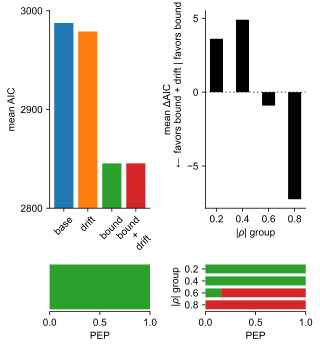

In [38]:
#NOTE: w/ new size of this figure y-axis for delta AIC plot has to be manually adjusted to fit

shared_mods_bar = {'rsharedCLT':'base',
                   'bound_sharedCLT_vk':'drift',
                   'bound_rscaleCLT_sk':'bound', 
                   'bound_rscaleCLT_vk':'bound\n+\ndrift'
                  }

with mpl.rc_context({'mathtext.fontset':'custom'}):

    fig,ax=plt.subplots(nrows=2,ncols=2, gridspec_kw={'height_ratios':[4,1]},layout='constrained')


    #plot AIC over all rho conds
    for m,l in shared_mods_bar.items():
        ax[0,0].bar(x=l,height=fits_shared_ave.loc[m,'mean_aic'])
    ax[0,0].set_ylim([2800,3000])
    ax[0,0].locator_params(nbins=3, axis='y')
    ax[0,0].set_ylabel('mean AIC')
    ax[0,0].set_xticks(ax[0,0].get_xticks(),shared_mods_bar.values(),rotation=45, ha='center')

    #plot PEP over all rho conds
    left = 0
    for m,l in shared_mods_bar.items():
        p=ax[1,0].barh(y=0,width=fits_shared_ave.loc[m,'PEP'],height=0.2,left=left)
        #print(l)
        left += fits_shared_ave.loc[m,'PEP']

    ax[1,0].set_yticks([])
    ax[1,0].set_xlim((0,1))
    ax[1,0].set_xlabel('PEP')
    ax[1,0].spines['left'].set_visible(False)


    #aic by rho cond
    rho_vk_sk_diff = fits_shared_ave_rho.loc['bound_rscaleCLT_vk','mean_aic'] - fits_shared_ave_rho.loc['bound_rscaleCLT_sk','mean_aic']
    ax[0,1].bar(rho_vk_sk_diff.index,rho_vk_sk_diff.values,color='k',width=0.1)
    ax[0,1].axhline(0,linestyle=':',color='k',alpha=0.5)
    ax[0,1].set_xlabel(r'$|\rho|$ group')
    ax[0,1].set_ylabel(r'''mean $\Delta$AIC
                       $\leftarrow$ favors bound + drift | favors bound $\rightarrow$''')
    ax[0,1].set_xticks(rho_vk_sk_diff.index)
    ax[0,1].locator_params(nbins=3, axis='y')

    #pep by rho cond
    left = np.zeros(4)
    for m,l in shared_mods_bar.items():
        p=ax[1,1].barh(y=rho_conds,width=fits_shared_ave_rho.loc[m,'PEP'],height=0.15,left=left)
        #print(l)
        #ax[0,0].bar_label(p, label_type='center')
        left += fits_shared_ave_rho.loc[m,'PEP']
    ax[1,1].set_yticks(rho_conds)
    ax[1,1].set_ylim(ax[1,1].get_ylim()[::-1])
    ax[1,1].set_ylabel(r'$|\rho|$ group')
    ax[1,1].set_xticks((0,0.5,1.0))
    ax[1,1].set_xlim((0,1))
    ax[1,1].set_xlabel('PEP')
    ax[1,1].spines['left'].set_visible(False)

    fig.set_figwidth(11*cm)
    fig.set_figheight(12*cm)

    fig.savefig(path.join(fig_dir,'fig6_fit_stats_%s.pdf' % date.today()))


## parameters

In [39]:
#Add column for best-fit params based on rho cond (as in model plots above)
if 'best' not in params_shared.index.get_level_values('model'):
    params_shared = params_shared.copy()

    best_params_rlow = params_shared.loc[idx[0.2:0.4,'bound_rscaleCLT_sk',:,:],:].rename(index={'bound_rscaleCLT_sk':'best'})
    best_params_rhigh = params_shared.loc[idx[0.6:0.8,'bound_rscaleCLT_vk',:,:],:].rename(index={'bound_rscaleCLT_vk':'best'})

    display(best_params_rlow)
    display(best_params_rlow.index.get_level_values('rho_cond').unique())
    display(best_params_rlow.index.get_level_values('model').unique())

    display(best_params_rhigh)
    display(best_params_rhigh.index.get_level_values('rho_cond').unique())
    display(best_params_rhigh.index.get_level_values('model').unique())

    params_shared = pd.concat([params_shared,best_params_rlow,best_params_rhigh]).sort_index()

    display(params_shared)


value hit_boundary
rho_cond model subject                  param                               
0.2      best  5bd781291fd7c80001bb1fad B0             2.245772        False
                                        Rn            -0.273478        False
                                        Rp             0.046182        False
                                        driftSNR0     23.628701        False
                                        nondectime     0.632835        False
...                                                         ...          ...
0.4      best  6172eebe85de20b0b268d5c5 Rp             0.282853        False
                                        driftSNR0     22.526378        False
                                        nondectime     0.415631        False
                                        t              0.076749        False
                                        umixturecoef   0.005720        False

[350 rows x 2 columns]

Float64Index([0.2, 0.4], dtype='float64', name='rho_cond')

Index(['best'], dtype='object', name='model')

value hit_boundary
rho_cond model subject                  param                               
0.6      best  5b232f6838fc0c000131438c B0             2.660993        False
                                        Rn            -0.592863        False
                                        Rp             0.796928        False
                                        driftSNR0     13.839488        False
                                        driftSNRn     14.758347        False
...                                                         ...          ...
0.8      best  614fc66c9094c0a205c09a69 driftSNRn     12.838706        False
                                        driftSNRp     25.437486        False
                                        nondectime     0.614558        False
                                        t              0.328012        False
                                        umixturecoef   0.013044        False

[450 rows x 2 columns]

Float64Index([0.6, 0.8], dtype='float64', name='rho_cond')

Index(['best'], dtype='object', name='model')

value  \
rho_cond model      subject                  param                     
0.2      best       5bd781291fd7c80001bb1fad B0             2.245772   
                                             Rn            -0.273478   
                                             Rp             0.046182   
                                             driftSNR0     23.628701   
                                             nondectime     0.632835   
...                                                              ...   
0.8      rsharedCLT 614fc66c9094c0a205c09a69 B0             2.557039   
                                             driftSNR0     18.014921   
                                             nondectime     0.583738   
                                             t              0.460736   
                                             umixturecoef   0.126063   

                                                          hit_boundary  
rho_cond model      subject                  param                      
0.2      best       5bd781291fd7c80001bb1fad B0                  False  
                                             Rn                  False  
                                             Rp                  False  
                                             driftSNR0           False  
                                             nondectime          False  
...                                                                ...  
0.8      rsharedCLT 614fc66c9094c0a205c09a69 B0                  False  
                                             driftSNR0           False  
                                             nondectime          False  
                                             t                   False  
                                             umixturecoef        False  

[3600 rows x 2 columns]

In [40]:
#average over participants

params_shared_ave = \
    params_shared.drop(['hit_boundary'],axis=1).groupby(['model','rho_cond','param']).agg(['mean','std','sem'])
display(params_shared_ave)

value                    
                                       mean       std       sem
model      rho_cond param                                      
best       0.2      B0             1.914884  0.583681  0.116736
                    Rn            -0.136180  0.085770  0.017154
                    Rp             0.089526  0.136183  0.027237
                    driftSNR0     17.456285  3.996209  0.799242
                    nondectime     0.375628  0.228551  0.045710
...                                     ...       ...       ...
rsharedCLT 0.8      B0             1.778922  0.490145  0.098029
                    driftSNR0     20.303667  3.089487  0.617897
                    nondectime     0.359283  0.171029  0.034206
                    t              0.213635  0.130016  0.026003
                    umixturecoef   0.119047  0.048949  0.009790

[144 rows x 3 columns]

## paper plots (using best model for primary analyses)
If you want plots for a different model with correlation parameters, change the param_plot_model variable below.

In [41]:
#first lets plot the Rn/Rp params across all rho_conds
param_plot_model = 'best'


#also do for subject-level (I'm doing this in reverse order from usual but whatever)
rho_params_subj = params_shared.loc[idx[:,param_plot_model,:,['Rn','Rp']],['value']].droplevel('model',axis=0).copy()
rho_params_subj['rho'] = rho_params_subj.index.get_level_values('rho_cond')
rho_params_subj['rho']*=2*(rho_params_subj.index.get_level_values('param')=='Rp')-1
display(rho_params_subj)

#also do for average level (need to do things a littel differently here b/c want to average in z space)
rho_params=rho_params_subj.groupby(['rho_cond','param','rho'])[['value']].agg([meanzr,sem_low,sem_high])
rho_params=rho_params.rename(columns={'meanzr':'mean'},level=1).reset_index(level='rho') #clean up
display(rho_params)

value  rho
rho_cond subject                  param               
0.2      5bd781291fd7c80001bb1fad Rn    -0.273478 -0.2
                                  Rp     0.046182  0.2
         5d645bf6912c630018e269e3 Rn    -0.118976 -0.2
                                  Rp     0.149711  0.2
         5e705a1be6c65a62c56a3143 Rn    -0.107345 -0.2
...                                           ...  ...
0.8      613ab15693299c16c27d8c92 Rp     0.629640  0.8
         613da525a95f61825e2c6b68 Rn    -0.719416 -0.8
                                  Rp     0.220026  0.8
         614fc66c9094c0a205c09a69 Rn    -0.746663 -0.8
                                  Rp     0.539617  0.8

[200 rows x 2 columns]

rho     value                    
                         mean   sem_low  sem_high
rho_cond param                                   
0.2      Rn    -0.2 -0.137112  0.017197  0.017280
         Rp     0.2  0.091151  0.027684  0.027544
0.4      Rn    -0.4 -0.292792  0.015185  0.015334
         Rp     0.4  0.245459  0.032655  0.032107
0.6      Rn    -0.6 -0.490428  0.016163  0.016507
         Rp     0.6  0.499499  0.044523  0.042032
0.8      Rn    -0.8 -0.697321  0.011203  0.011554
         Rp     0.8  0.575153  0.040828  0.038151

In [42]:
#compute bound scale factor (deviation)
rho_params_subj['scale_dev'] = np.sqrt(1+rho_params_subj['value'])/np.sqrt(1+rho_params_subj['rho'])

##should this be averaged over scale or rho???? (based on the rho average, which seems OK given previous plot?)
rho_params['scale_dev'] = np.sqrt(1+rho_params[('value','mean')])/np.sqrt(1+rho_params['rho'])

#compute naive line (don't take correlation into account)
param_rho_xlim = [-0.85,0.85]
param_rho_xrange = np.linspace(param_rho_xlim[0],param_rho_xlim[1],500)
param_rho_naive = 1/np.sqrt(1+param_rho_xrange)

In [43]:
#save out rho params for analysis
if False:
    rho_params_subj.to_csv(path.join(data_dir,'rho_params_best_%s.csv' % date.today()),index=True)
    
#also save out all params for best model
if False:
    params_shared.xs('best',level='model')[['value']].to_csv(path.join(data_dir,'params_best_%s.csv' % date.today()),index=True)

In [44]:
params_shared

value  \
rho_cond model      subject                  param                     
0.2      best       5bd781291fd7c80001bb1fad B0             2.245772   
                                             Rn            -0.273478   
                                             Rp             0.046182   
                                             driftSNR0     23.628701   
                                             nondectime     0.632835   
...                                                              ...   
0.8      rsharedCLT 614fc66c9094c0a205c09a69 B0             2.557039   
                                             driftSNR0     18.014921   
                                             nondectime     0.583738   
                                             t              0.460736   
                                             umixturecoef   0.126063   

                                                          hit_boundary  
rho_cond model      subject                  param                      
0.2      best       5bd781291fd7c80001bb1fad B0                  False  
                                             Rn                  False  
                                             Rp                  False  
                                             driftSNR0           False  
                                             nondectime          False  
...                                                                ...  
0.8      rsharedCLT 614fc66c9094c0a205c09a69 B0                  False  
                                             driftSNR0           False  
                                             nondectime          False  
                                             t                   False  
                                             umixturecoef        False  

[3600 rows x 2 columns]

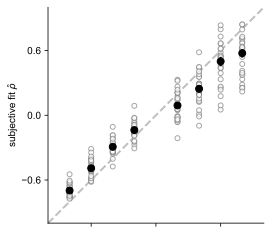

In [45]:
fig,ax=plt.subplots()
ax.axline((0, 0), slope=1,linestyle='--',color='grey',alpha=0.5,linewidth=2)

ax.plot(rho_params_subj['rho'],rho_params_subj['value'],linestyle='',marker='.',markersize=10,
        markerfacecolor='white',markeredgecolor='grey',alpha=0.7)

ax.errorbar(rho_params['rho'],rho_params[('value','mean')],
            yerr=rho_params[[('value','sem_low'),('value','sem_high')]].to_numpy().T,
            linestyle='',marker='.',markersize=14,elinewidth=2,color='black')
ax.set_xticks([-0.6,0,0.6])# rho_params['rho'])
ax.set_xticklabels([])
ax.set_yticks([-0.6,0,0.6])#rho_params['rho'])
ax.set_ylim((-1,1))
ax.set_xlim((-1,1))
##ax.set_xlabel('objective correlation')
ax.set_ylabel(r'subjective fit $\hat{\rho}$')
fig.set_figwidth(9.85*cm)
ax.set_aspect('equal')
fig.savefig(path.join(fig_dir,'fig6_top_%s_%s.pdf' % (param_plot_model,date.today())))

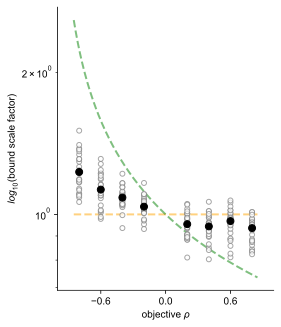

In [46]:
#green = naive, orange = ideal to match Josh neo-SSE analysis fig

#same as above, log scale

fig,ax=plt.subplots()
ax.axhline(1,xmin=(param_rho_xlim[0]+1)/2,xmax=(param_rho_xlim[1]+1)/2,linestyle='--',color='orange',alpha=0.5,linewidth=2)
ax.plot(param_rho_xrange,param_rho_naive,linestyle='--',color='green',alpha=0.5,linewidth=2)
ax.plot(rho_params_subj['rho'],rho_params_subj['scale_dev'],linestyle='',marker='.',markersize=10,
        markerfacecolor='white',markeredgecolor='grey',alpha=0.7)
ax.plot(rho_params['rho'],rho_params['scale_dev'],linestyle='',marker='.',markersize=14,color='black')


ax.set_xlim((-1,1))
ax.set_xticks([-0.6,0,0.6])# rho_params['rho'])
ax.set_yticks(np.arange(1,3,0.5))

ax.set_xlabel(r'objective $\rho$')
ax.set_ylabel(r'$log_{10}$(bound scale factor)');
ax.set_yscale('log')

#size calculated to match axis of top plot
set_size(7.6337*cm,10*cm,ax) 


fig.savefig(path.join(fig_dir,'fig6_bottom_log_%s_%s.pdf' % (param_plot_model,date.today())))

## drift analysis


### drift as function of rho
In bound + drift model, how does drift change across correlation conditions

In [47]:
drift_param_names = ['driftSNRn','driftSNR0','driftSNRp']
drift_labels = [r'$k_-$',r'$k_0$',r'$k_+$']
drift_rho_conds = [0.6,0.8]

In [48]:
drift_params = params_shared.loc[drift_rho_conds,'bound_rscaleCLT_vk',:,drift_param_names].droplevel('model',axis=0)
display(drift_params)

drift_params_ave = params_shared_ave.loc['bound_rscaleCLT_vk',drift_rho_conds,drift_param_names].droplevel('model',axis=0)
display(drift_params_ave)

value hit_boundary
rho_cond subject                  param                            
0.6      5b232f6838fc0c000131438c driftSNRn  14.758347        False
         5b8c8e7d0c740e00019d55c3 driftSNRn  27.390961        False
         5e66db7ade78964625f46543 driftSNRn  22.578572        False
         5ed2ccbaf064eb0eb69e7964 driftSNRn  14.618909        False
         5f6a825c6b0125156e8c1b5f driftSNRn  20.225445        False
...                                                ...          ...
0.8      612eb19f8a38f5cbf48d287a driftSNRp  18.450623        False
         613a20d9d4ffdd4ffe6e0f93 driftSNRp  32.596990        False
         613ab15693299c16c27d8c92 driftSNRp  19.693184        False
         613da525a95f61825e2c6b68 driftSNRp  15.310077        False
         614fc66c9094c0a205c09a69 driftSNRp  25.437486        False

[150 rows x 2 columns]

value                    
                         mean       std       sem
rho_cond param                                   
0.6      driftSNRn  15.689664  4.381946  0.876389
         driftSNR0  18.209215  4.500129  0.900026
         driftSNRp  18.561935  4.467613  0.893523
0.8      driftSNRn  14.844348  3.177885  0.635577
         driftSNR0  18.682919  4.339017  0.867803
         driftSNRp  20.700801  5.368293  1.073659

/var/folders/3_/40m5_51d419__yjj36qs3p_m0001g2/T/ipykernel_8157/3575065344.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axi.set_xticklabels(drift_labels)


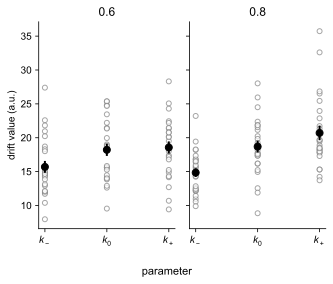

In [49]:
fig,ax=plt.subplots(nrows=1,ncols=len(drift_rho_conds),sharex=True,sharey=True)

for axi,(ri,dfi),(ria,dfi_ave) in zip(ax,drift_params.groupby('rho_cond'),drift_params_ave.groupby('rho_cond')):
    #print(ri)
    assert ri==ria
    #display(dfi_ave)
    axi.plot(dfi.index.get_level_values('param'),dfi['value'],linestyle='',marker='.',markersize=10,
        markerfacecolor='white',markeredgecolor='grey',alpha=0.7)
    axi.errorbar(dfi_ave.index.get_level_values('param'),dfi_ave['value','mean'],dfi_ave['value','sem'],
                            marker='.',linestyle='',color='k',markersize=14,elinewidth=2)
    axi.set_title(ri)
    axi.set_xticklabels(drift_labels)

ax[0].set_ylabel('drift value (a.u.)')
fig.supxlabel('parameter')

fig.set_figwidth(12*cm)
fig.set_figheight(10*cm)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig5_SUPP_drift_params_%s.pdf' % date.today()))

# examinging learning effects
Models fit separately on first and second half of the data. Used in Fig 8.

In [50]:
half_mods = ['bound_rscaleCLT_sk','bound_rscaleCLT_vk']
half = [1,2]

half_samps = {}
for rc in rho_conds:
    half_samps[rc] = {}
    for h in half:
        half_samps[rc][h],_ = \
            gdw.load_data(datat.loc[(datat.rho_cond==rc)].copy(),
                rt="RT",conds=['rho','mu'],
                verbose=False,debug=False,postproc=lambda x: helpers.split_postproc(x,h))
        
#quick and dirty gut check
assert np.all(np.array([len(x) for hd in half_samps.values() for x in hd.values()])==25), \
    "Incorrect number of subjects per corr!"

In [51]:
#get fit for all models
half_fits = {}
for rc in rho_conds:
    half_fits[rc] = {}
    for m in half_mods:
        half_fits[rc][m] = {}
        for h in half:
            half_fits[rc][m][h] = \
                gdw.load_models(path.join(fit_dir,'%s_*_r%s_h%d*_2023-09-??' % (m,rho_conds_filestring[rc],h)),
                                verbose=False)
            half_fits[rc][m][h] = {f.subject:f for f in half_fits[rc][m][h]}

print(np.array([len(x) for x in half_fits.values()]))
print(np.array([len(y) for x in half_fits.values() for y in x.values()]))
print(np.array([len(z) for x in half_fits.values() for y in x.values() for z in y.values()]))

[2 2 2 2]
[2 2 2 2 2 2 2 2]
[25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25]


In [52]:
#let's actually get params first so we can check on boundary issues before going to the trouble of solving

params_half = []
for rc,fdict in half_fits.items():
    print(rc)
    for m,hdict in fdict.items():
        print(m)
        for h,fits in hdict.items():
            print(h)
            #print(fits)
            if len(fits) > 0:
                parami = ddm_corr.get_all_params(fits)
                parami['rho_cond'] = rc
                parami['model'] = m
                parami['half'] = h
                params_half.append(parami)
    
params_half = pd.concat(params_half)
params_half.set_index(['rho_cond','model','half','subject'],inplace=True,append=True)
params_half = params_half.reorder_levels(['rho_cond','model','half','subject','param'])
params_half.sort_index(inplace=True)

0.2
bound_rscaleCLT_sk
1
               value hit_boundary                   subject
param                                                      
driftSNR0  16.178319        False  613a3fa3cd445d55f2e1a486
Rn         -0.107199        False  613a3fa3cd445d55f2e1a486
B0          1.718084        False  613a3fa3cd445d55f2e1a486
Rp          0.329602        False  613a3fa3cd445d55f2e1a486
t           0.046906         True  613a3fa3cd445d55f2e1a486
                 value hit_boundary                   subject
param                                                        
t             0.046906         True  613a3fa3cd445d55f2e1a486
umixturecoef  0.001000         True  613a3fa3cd445d55f2e1a486
umixturecoef  0.001000         True  5f30ee4c383a0d56521f69c7
umixturecoef  0.001000         True  5f867f7190d5551ccb72d7bf
umixturecoef  0.001000         True  613a8ef513f5e9934f6f6fb3
t             0.046648         True  616e401a1a88b28ca7581bb6
umixturecoef  0.001000         True  616e401a1a88b28ca7581b

In [53]:
#some sanity checks
assert np.all(params_half.xs('t',level='param').groupby(['model','rho_cond','half']).size().to_numpy()==25), \
    "Wrong number of subjects per model in params"
assert len(params_half.xs('t',level='param').groupby(['model','rho_cond','half']).size())==\
    len(rho_conds)*len(half_mods)*len(half), \
    "Wrong number of model/rho cond combinations in params"

#first pass check for any problematic fits re: param bounds
display(params_half.loc[params_half.hit_boundary].groupby('param').hit_boundary.value_counts())
display(params_half.loc[params_half.hit_boundary].groupby('param').min())
display(params_half.loc[params_half.hit_boundary].groupby('param').max())

param         hit_boundary
nondectime    True              5
t             True            122
umixturecoef  True            163
Name: hit_boundary, dtype: int64

,value,hit_boundary
param,,
nondectime,0.000502,True
t,0.000000,True
umixturecoef,0.001000,True


,value,hit_boundary
param,,
nondectime,0.029457,True
t,0.059972,True
umixturecoef,0.003857,True


In [54]:
do_sols = False
if do_sols:
    half_soldf = []
    #half_soldf = {k:{} for k in half_mods}
    for (sk,sv),(mk,mv) in zip(half_samps.items(),half_fits.items()):
        assert sk==mk
        print(sk)
        for mmk,mmv in mv.items():
            print(mmk)
            #half_soldf[mmk][sk] = {}
            for (shk,shv),(mmhk,mmhv) in zip(sv.items(),mmv.items()):
                assert shk==mmhk
                print(shk)
                
                soldf = ddm_corr.get_all_sols(shv,mmhv)
                #soldf = {}
                soldf['rho_cond'] = sk
                soldf['model'] = mmk
                soldf['half'] = shk
                print(soldf)
                
                half_soldf.append(soldf)
                #half_soldf[mmk][sk][shk] = soldf
                
    with open(path.join(fit_dir,'half_sols_%s' % date.today()),'wb') as f:
             pickle.dump(half_soldf,f)
else:
    with open(path.join(fit_dir,'half_sols_2023-09-11'),'rb') as f:
        half_soldf = pickle.load(f)
        
        
half_soldf = pd.concat(half_soldf,ignore_index=True).set_index(['model','subject','rho_cond','half'])

#some quick sanity checks
assert np.all(half_soldf.value_counts(['model','subject','half'])==12), 'Incorrect number of conditions per fit!'
assert np.array_equal(half_soldf.index.unique('subject').sort_values(),subj.subject), 'Subject fits missing!'
assert len(half_soldf)==3*2*2*2*2*100, 'Incorrect number of total predictions!'

half_soldf

rho       mu  \
model              subject                  rho_cond half                 
bound_rscaleCLT_sk 5f30ee4c383a0d56521f69c7 0.2      1     0.0 -0.02818   
                                                     1     0.2 -0.03088   
                                                     1     0.2 -0.07719   
                                                     1    -0.2  0.06302   
                                                     1    -0.2 -0.02521   
...                                                        ...      ...   
bound_rscaleCLT_vk 602f07904b3c5c2406aff708 0.8      2     0.8 -0.05803   
                                                     2     0.0 -0.04325   
                                                     2     0.8  0.05803   
                                                     2     0.0  0.04325   
                                                     2     0.8 -0.02321   

                                                           mean_corr  \
model              subject                  rho_cond half              
bound_rscaleCLT_sk 5f30ee4c383a0d56521f69c7 0.2      1      0.790584   
                                                     1      0.779436   
                                                     1      0.960574   
                                                     1      0.968084   
                                                     1      0.793458   
...                                                              ...   
bound_rscaleCLT_vk 602f07904b3c5c2406aff708 0.8      2      0.959149   
                                                     2      0.934940   
                                                     2      0.959149   
                                                     2      0.934940   
                                                     2      0.771244   

                                                           mean_err  \
model              subject                  rho_cond half             
bound_rscaleCLT_sk 5f30ee4c383a0d56521f69c7 0.2      1     0.209416   
                                                     1     0.220564   
                                                     1     0.039426   
                                                     1     0.031916   
                                                     1     0.206542   
...                                                             ...   
bound_rscaleCLT_vk 602f07904b3c5c2406aff708 0.8      2     0.040851   
                                                     2     0.065060   
                                                     2     0.040851   
                                                     2     0.065060   
                                                     2     0.228756   

                                                           mean_RT_corr  \
model              subject                  rho_cond half                 
bound_rscaleCLT_sk 5f30ee4c383a0d56521f69c7 0.2      1         3.465837   
                                                     1         3.197700   
                                                     1         2.278462   
                                                     1         2.450306   
                                                     1         3.536027   
...                                                                 ...   
bound_rscaleCLT_vk 602f07904b3c5c2406aff708 0.8      2         1.136560   
                                                     2         1.322693   
                                                     2         1.136560   
                                                     2         1.322693   
                                                     2         1.383037   

                                                           mean_undec  \
model              subject                  rho_cond half               
bound_rscaleCLT_sk 5f30ee4c383a0d56521f69c7 0.2      1       0.000377   
                           

In [55]:
#need to split data in half for merging urg, also slightly janky
datat_half = {h:datat.groupby('subject'
                           ,sort=False,as_index=False,group_keys=False).apply(lambda x: helpers.split_postproc(x,h))
              for h in half}
for k,v in datat_half.items():
    v['half'] = k
    
datat_half = pd.concat(datat_half.values())
datat_half

,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,SNR,half
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,0.14,1
1,2,5f3ee36d0306de1a411882a5,-0.2,-0.04224,2.0112,0.0,1.0,-0.892109,0.356901,0.2,-0.89,1
2,3,5f3ee36d0306de1a411882a5,0.0,-0.01889,2.4702,0.0,1.0,-0.142733,0.356901,0.2,-0.14,1
3,4,5f3ee36d0306de1a411882a5,0.0,0.01889,2.4292,1.0,1.0,0.142733,0.356901,0.2,0.14,1
4,5,5f3ee36d0306de1a411882a5,0.2,-0.02069,3.5572,0.0,1.0,-0.142692,0.356901,0.2,-0.14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
76752,764,5e95d4f551598d01d6d455af,-0.8,-0.00788,3.7340,0.0,1.0,-0.124189,0.310849,0.8,-0.12,2
76753,765,5e95d4f551598d01d6d455af,0.8,0.05914,1.1230,1.0,1.0,0.777231,0.310849,0.8,0.78,2
76754,766,5e95d4f551598d01d6d455af,-0.8,0.00788,4.8250,0.0,0.0,0.124189,0.310849,0.8,0.12,2
76755,767,5e95d4f551598d01d6d455af,0.8,-0.05914,0.4020,0.0,1.0,-0.777231,0.310849,0.8,-0.78,2


In [56]:
#combine predictions w/ data
    
datat_mhalf_dict = {m:ddm_corr.data_pred_merge(datat_half,sols,on=['subject','half','rho_cond','rho','mu']) 
                 for m,sols in half_soldf.groupby('model')}




   trial                   subject  rho       mu      RT  response  correct  \
0      1  5f3ee36d0306de1a411882a5  0.2  0.02069  1.6825       1.0      1.0   
1     18  5f3ee36d0306de1a411882a5  0.2  0.02069  2.9287       1.0      1.0   
2     36  5f3ee36d0306de1a411882a5  0.2  0.02069  2.6330       0.0      0.0   
3     40  5f3ee36d0306de1a411882a5  0.2  0.02069  2.6890       1.0      1.0   
4     59  5f3ee36d0306de1a411882a5  0.2  0.02069  1.7222       0.0      0.0   

     SNRraw  threshold  rho_cond   SNR  half  mean_corr  mean_err  \
0  0.142692   0.356901       0.2  0.14     1   0.751278  0.248722   
1  0.142692   0.356901       0.2  0.14     1   0.751278  0.248722   
2  0.142692   0.356901       0.2  0.14     1   0.751278  0.248722   
3  0.142692   0.356901       0.2  0.14     1   0.751278  0.248722   
4  0.142692   0.356901       0.2  0.14     1   0.751278  0.248722   

   mean_RT_corr  mean_RT_err  pred_response  
0       3.12026     3.470023       0.751278  
1       3.12026   

In [57]:
#bind all predictions into one df


datat_mhalf = datat_mhalf_dict[half_mods[0]].drop(['mean_corr','mean_err'],axis=1).merge(
    datat_mhalf_dict[half_mods[1]][['rho_cond','subject','half','trial','pred_response','mean_RT_corr','mean_RT_err']],
                                                         on=['rho_cond','subject','half','trial'],
                                                        suffixes=('_'+x for x in half_mods),
                                                          validate='1:1')
datat_mhalf

,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,SNR,half,mean_RT_corr_bound_rscaleCLT_sk,mean_RT_err_bound_rscaleCLT_sk,pred_response_bound_rscaleCLT_sk,pred_response_bound_rscaleCLT_vk,mean_RT_corr_bound_rscaleCLT_vk,mean_RT_err_bound_rscaleCLT_vk
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,0.14,1,3.120260,3.470023,0.751278,0.780500,3.244028,3.655286
1,18,5f3ee36d0306de1a411882a5,0.2,0.02069,2.9287,1.0,1.0,0.142692,0.356901,0.2,0.14,1,3.120260,3.470023,0.751278,0.780500,3.244028,3.655286
2,36,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6330,0.0,0.0,0.142692,0.356901,0.2,0.14,1,3.120260,3.470023,0.751278,0.780500,3.244028,3.655286
3,40,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6890,1.0,1.0,0.142692,0.356901,0.2,0.14,1,3.120260,3.470023,0.751278,0.780500,3.244028,3.655286
4,59,5f3ee36d0306de1a411882a5,0.2,0.02069,1.7222,0.0,0.0,0.142692,0.356901,0.2,0.14,1,3.120260,3.470023,0.751278,0.780500,3.244028,3.655286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76113,719,5e95d4f551598d01d6d455af,0.8,0.05914,0.6540,1.0,1.0,0.777231,0.310849,0.8,0.78,2,1.568901,1.915325,0.807556,0.864708,1.379574,1.854978
76114,727,5e95d4f551598d01d6d455af,0.8,0.05914,0.6460,1.0,1.0,0.777231,0.310849,0.8,0.78,2,1.568901,1.915325,0.807556,0.864708,1.379574,1.854978
76115,733,5e95d4f551598d01d6d455af,0.8,0.05914,0.5190,1.0,1.0,0.777231,0.310849,0.8,0.78,2,1.568901,1.915325,0.807556,0.864708,1.379574,1.854978
76116,745,5e95d4f551598d01d6d455af,0.8,0.05914,1.3880,1.0,1.0,0.777231,0.310849,0.8,0.78,2,1.568901,1.915325,0.807556,0.864708,1.379574,1.854978


In [58]:
#add best model cols

datat_mhalf['mean_RT_corr_best'] = datat_mhalf.apply(lambda x: x['mean_RT_corr_bound_rscaleCLT_sk'] \
                    if (x['rho_cond'] < 0.5) else x['mean_RT_corr_bound_rscaleCLT_vk'],axis=1)
assert datat_mhalf.loc[datat_mhalf.rho_cond<0.5,'mean_RT_corr_bound_rscaleCLT_sk'].equals(\
    datat_mhalf.loc[datat_mhalf.rho_cond<0.5,'mean_RT_corr_best'])
assert datat_mhalf.loc[datat_mhalf.rho_cond>0.5,'mean_RT_corr_bound_rscaleCLT_vk'].equals(\
    datat_mhalf.loc[datat_mhalf.rho_cond>0.5,'mean_RT_corr_best'])

datat_mhalf['mean_RT_err_best'] = datat_mhalf.apply(lambda x: x['mean_RT_err_bound_rscaleCLT_sk'] \
                    if (x['rho_cond'] < 0.5) else x['mean_RT_err_bound_rscaleCLT_vk'],axis=1)
assert datat_mhalf.loc[datat_mhalf.rho_cond<0.5,'mean_RT_err_bound_rscaleCLT_sk'].equals(\
    datat_mhalf.loc[datat_mhalf.rho_cond<0.5,'mean_RT_err_best'])
assert datat_mhalf.loc[datat_mhalf.rho_cond>0.5,'mean_RT_err_bound_rscaleCLT_vk'].equals(\
    datat_mhalf.loc[datat_mhalf.rho_cond>0.5,'mean_RT_err_best'])

datat_mhalf['pred_response_best'] = datat_mhalf.apply(lambda x: x['pred_response_bound_rscaleCLT_sk'] \
                    if (x['rho_cond'] < 0.5) else x['pred_response_bound_rscaleCLT_vk'],axis=1)
assert datat_mhalf.loc[datat_mhalf.rho_cond<0.5,'pred_response_bound_rscaleCLT_sk'].equals(\
    datat_mhalf.loc[datat_mhalf.rho_cond<0.5,'pred_response_best'])
assert datat_mhalf.loc[datat_mhalf.rho_cond>0.5,'pred_response_bound_rscaleCLT_vk'].equals(\
    datat_mhalf.loc[datat_mhalf.rho_cond>0.5,'pred_response_best'])
display(datat_mhalf.head())

,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,...,half,mean_RT_corr_bound_rscaleCLT_sk,mean_RT_err_bound_rscaleCLT_sk,pred_response_bound_rscaleCLT_sk,pred_response_bound_rscaleCLT_vk,mean_RT_corr_bound_rscaleCLT_vk,mean_RT_err_bound_rscaleCLT_vk,mean_RT_corr_best,mean_RT_err_best,pred_response_best
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,...,1,3.12026,3.470023,0.751278,0.7805,3.244028,3.655286,3.12026,3.470023,0.751278
1,18,5f3ee36d0306de1a411882a5,0.2,0.02069,2.9287,1.0,1.0,0.142692,0.356901,0.2,...,1,3.12026,3.470023,0.751278,0.7805,3.244028,3.655286,3.12026,3.470023,0.751278
2,36,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6330,0.0,0.0,0.142692,0.356901,0.2,...,1,3.12026,3.470023,0.751278,0.7805,3.244028,3.655286,3.12026,3.470023,0.751278
3,40,5f3ee36d0306de1a411882a5,0.2,0.02069,2.6890,1.0,1.0,0.142692,0.356901,0.2,...,1,3.12026,3.470023,0.751278,0.7805,3.244028,3.655286,3.12026,3.470023,0.751278
4,59,5f3ee36d0306de1a411882a5,0.2,0.02069,1.7222,0.0,0.0,0.142692,0.356901,0.2,...,1,3.12026,3.470023,0.751278,0.7805,3.244028,3.655286,3.12026,3.470023,0.751278


In [59]:
#average for plotting

mod_cols_resp = ['_'.join(x) for x in product(['pred_response'],half_mods+['best'])]
mod_cols_RT = ['_'.join(x) for x in product(['mean_RT_corr','mean_RT_err'],half_mods+['best'])]
mod_cols_suffix = ['_'+x for x in half_mods]
mod_lines = [':','-',(0,(1,10)),(0,(5,10))]

datat_mhalf_psycho_ave = \
    datat_mhalf[['half','subject','rho_cond','rho','SNR','mu','response']+mod_cols_resp].groupby(['half','subject','rho_cond','rho','SNR','mu']).agg(['mean','std','sem'])
display(datat_mhalf_psycho_ave.groupby('rho_cond').head())

datat_mhalf_chrono_ave = \
    datat_mhalf[['half','subject','rho_cond','rho','SNR','mu','correct','RT']+mod_cols_RT].groupby(['half','subject','rho_cond','rho','SNR','mu','correct']).agg(['mean','std','sem'])
display(datat_mhalf_chrono_ave.groupby('rho_cond').head())

response  \
                                                                mean   
half subject                  rho_cond rho  SNR   mu                   
1    575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350  0.093750   
                                            -0.12 -0.01340  0.343750   
                                             0.12  0.01340  0.656250   
                                             0.75  0.03350  1.000000   
                                        0.0 -0.75 -0.04325  0.125000   
     58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897  0.071429   
                                            -0.12 -0.00759  0.500000   
                                             0.12  0.00759  0.812500   
                                             0.72  0.01897  0.968750   
                                        0.0 -0.72 -0.04241  0.000000   
     5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987  0.093750   
                                            -0.14 -0.01195  0.375000   
                                             0.14  0.01195  0.781250   
                                             0.89  0.02987  0.937500   
                                        0.0 -0.89 -0.04723  0.250000   
     5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015  0.031250   
                                            -0.13 -0.01606  0.312500   
                                             0.13  0.01606  0.687500   
                                             0.81  0.04015  0.968750   
                                        0.0 -0.81 -0.04489  0.000000   

                                                                      \
                                                                 std   
half subject                  rho_cond rho  SNR   mu                   
1    575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350  0.296145   
                                            -0.12 -0.01340  0.482559   
                                             0.12  0.01340  0.482559   
                                             0.75  0.03350  0.000000   
                                        0.0 -0.75 -0.04325  0.336011   
     58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897  0.262265   
                                            -0.12 -0.00759  0.508001   
                                             0.12  0.00759  0.396558   
                                             0.72  0.01897  0.176777   
                                        0.0 -0.72 -0.04241  0.000000   
     5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987  0.296145   
                                            -0.14 -0.01195  0.491869   
                                             0.14  0.01195  0.420013   
                                             0.89  0.02987  0.245935   
                                        0.0 -0.89 -0.04723  0.439941   
     5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015  0.176777   
                                            -0.13 -0.01606  0.470929   
                                             0.13  0.01606  0.470929   
                                             0.81  0.04015  0.176777   
                                        0.0 -0.81 -0.04489  0.000000   

                                                                      \
                                                                 sem   
half subject                  rho_cond rho  SNR   mu                   
1    575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350  0.052351   
                                            -0.12 -0.01340  0.085305   
                                             0.12  0.01340  0.085305   
                                             0.75  0.03350  0.000000   
                                        0.0 -0.75 -0.04325  0.059399   
     58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897  0.049563   
                                            -0.12 -0.00759  0.089803   
                          

RT  \
                                                                        mean   
half subject                  rho_cond rho  SNR   mu       correct             
1    575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      4.470033   
                                                           1.0      3.031555   
                                            -0.12 -0.01340 0.0      3.418855   
                                                           1.0      3.261429   
                                             0.12  0.01340 0.0      2.716700   
     58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897 0.0      5.342000   
                                                           1.0      3.715231   
                                            -0.12 -0.00759 0.0      3.892562   
                                                           1.0      3.164875   
                                             0.12  0.00759 0.0      3.270833   
     5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987 0.0      5.012700   
                                                           1.0      3.064517   
                                            -0.14 -0.01195 0.0      3.577833   
                                                           1.0      3.235625   
                                             0.14  0.01195 0.0      3.301386   
     5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015 0.0      1.814000   
                                                           1.0      2.096597   
                                            -0.13 -0.01606 0.0      2.553170   
                                                           1.0      2.058636   
                                             0.13  0.01606 0.0      2.354940   

                                                                              \
                                                                         std   
half subject                  rho_cond rho  SNR   mu       correct             
1    575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      1.968183   
                                                           1.0      0.814288   
                                            -0.12 -0.01340 0.0      1.361267   
                                                           1.0      1.007931   
                                             0.12  0.01340 0.0      0.989235   
     58f82417edbd82000169bce8 0.8      -0.8 -0.72 -0.01897 0.0      1.035204   
                                                           1.0      2.066398   
                                            -0.12 -0.00759 0.0      1.904362   
                                                           1.0      1.579585   
                                             0.12  0.00759 0.0      0.716746   
     5b232f6838fc0c000131438c 0.6      -0.6 -0.89 -0.02987 0.0      4.018549   
                                                           1.0      1.040751   
                                            -0.14 -0.01195 0.0      1.692593   
                                                           1.0      1.323437   
                                             0.14  0.01195 0.0      1.425381   
     5bd781291fd7c80001bb1fad 0.2      -0.2 -0.81 -0.04015 0.0           NaN   
                                                           1.0      0.744182   
                                            -0.13 -0.01606 0.0      0.724531   
                                                           1.0      0.453032   
                                             0.13  0.01606 0.0      0.730811   

                                                                              \
                                                                         sem   
half subject                  rho_cond rho  SNR   mu       correct             
1    575f387c91f8b40006c332e1 0.4      -0.4 -0.75 -0.03350 0.0      1.136331   
                                                           1.0      0.15

In [60]:
#average over Ss

datat_mhalf_psycho_ave_all = \
    datat_mhalf_psycho_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['half','rho_cond','rho','uSNR']).agg(['mean','std','sem'])
display(datat_mhalf_psycho_ave_all)

datat_mhalf_chrono_ave_all = \
    datat_mhalf_chrono_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['half','rho_cond','rho','uSNR','correct']).agg(['mean','std','sem'])
display(datat_mhalf_chrono_ave_all)


response                      \
                                mean       std       sem   
half rho_cond rho  uSNR                                    
1    0.2      -0.2 -0.9239  0.075501  0.059197  0.011839   
                   -0.1480  0.278694  0.118491  0.023698   
                    0.1480  0.766913  0.095366  0.019073   
                    0.9239  0.918548  0.065056  0.013011   
               0.0 -0.9239  0.095059  0.087140  0.017428   
...                              ...       ...       ...   
2    0.8       0.0  0.9239  0.933584  0.058862  0.011772   
               0.8 -0.9239  0.068018  0.061618  0.012324   
                   -0.1480  0.265459  0.106305  0.021261   
                    0.1480  0.782570  0.083074  0.016615   
                    0.9239  0.943000  0.058175  0.011635   

                           pred_response_bound_rscaleCLT_sk            \
                                                       mean       std   
half rho_cond rho  uSNR                                                 
1    0.2      -0.2 -0.9239                         0.077679  0.043011   
                   -0.1480                         0.265561  0.046776   
                    0.1480                         0.734439  0.046776   
                    0.9239                         0.922321  0.043011   
               0.0 -0.9239                         0.080633  0.041109   
...                                                     ...       ...   
2    0.8       0.0  0.9239                         0.909284  0.042895   
               0.8 -0.9239                         0.109056  0.050440   
                   -0.1480                         0.296155  0.043351   
                    0.1480                         0.703845  0.043351   
                    0.9239                         0.890944  0.050440   

                                     pred_response_bound_rscaleCLT_vk  \
                                 sem                             mean   
half rho_cond rho  uSNR                                                 
1    0.2      -0.2 -0.9239  0.008602                         0.092168   
                   -0.1480  0.009355                         0.278355   
                    0.1480  0.009355                         0.721645   
                    0.9239  0.008602                         0.907832   
               0.0 -0.9239  0.008222                         0.081127   
...                              ...                              ...   
2    0.8       0.0  0.9239  0.008579                         0.925379   
               0.8 -0.9239  0.010088                         0.066869   
                   -0.1480  0.008670                         0.247205   
                    0.1480  0.008670                         0.752795   
                    0.9239  0.010088                         0.933131   

                                               pred_response_best            \
                                 std       sem               mean       std   
half rho_cond rho  uSNR                                                       
1    0.2      -0.2 -0.9239  0.049969  0.009994           0.077679  0.043011   
                   -0.1480  0.053693  0.010739           0.265561  0.046776   
                    0.1480  0.053693  0.010739           0.734439  0.046776   
                    0.9239  0.049969  0.009994           0.922321  0.043011   
               0.0 -0.9239  0.052633  0.010527           0.080633  0.041109   
...                              ...       ...                ...       ...   
2    0.8       0.0  0.9239  0.039115  0.007823           0.925379  0.039115   
               0.8 -0.9239  0.041477  0.008295           0.066869  0.041477   
                   -0.1480  0.054456  0.010891           0.247205  0.054456   
                    0.1480  0.054456  0.010891           0.752795  0.054456   
                    0.9239  0.041477  0.008295           0.933131  0.041477   

                                  

RT                      \
                                        mean       std       sem   
half rho_cond rho  uSNR    correct                                 
1    0.2      -0.2 -0.9239 0.0      2.490349  1.071486  0.228442   
                           1.0      2.472659  0.795742  0.159148   
                   -0.1480 0.0      3.104484  1.425962  0.285192   
                           1.0      2.930832  1.117412  0.223482   
                    0.1480 0.0      3.005102  1.459225  0.291845   
...                                      ...       ...       ...   
2    0.8       0.8 -0.1480 1.0      2.020812  0.780153  0.156031   
                    0.1480 0.0      2.194926  1.324711  0.264942   
                           1.0      1.985825  0.897575  0.179515   
                    0.9239 0.0      1.528097  1.057563  0.236478   
                           1.0      1.558976  0.493937  0.098787   

                                   mean_RT_corr_bound_rscaleCLT_sk            \
                                                              mean       std   
half rho_cond rho  uSNR    correct                                             
1    0.2      -0.2 -0.9239 0.0                            2.255082  0.713429   
                           1.0                            2.323865  0.707431   
                   -0.1480 0.0                            2.956254  1.045022   
                           1.0                            2.956254  1.045022   
                    0.1480 0.0                            2.956254  1.045022   
...                                                            ...       ...   
2    0.8       0.8 -0.1480 1.0                            2.040391  0.754878   
                    0.1480 0.0                            2.040391  0.754878   
                           1.0                            2.040391  0.754878   
                    0.9239 0.0                            1.626434  0.535550   
                           1.0                            1.668523  0.528160   

                                             mean_RT_corr_bound_rscaleCLT_vk  \
                                         sem                            mean   
half rho_cond rho  uSNR    correct                                             
1    0.2      -0.2 -0.9239 0.0      0.152104                        2.290962   
                           1.0      0.141486                        2.350768   
                   -0.1480 0.0      0.209004                        2.921473   
                           1.0      0.209004                        2.921473   
                    0.1480 0.0      0.209004                        2.921473   
...                                      ...                             ...   
2    0.8       0.8 -0.1480 1.0      0.150976                        2.050098   
                    0.1480 0.0      0.150976                        2.050098   
                           1.0      0.150976                        2.050098   
                    0.9239 0.0      0.119753                        1.530894   
                           1.0      0.105632                        1.555812   

                                                       mean_RT_corr_best  ...  \
                                         std       sem              mean  ...   
half rho_cond rho  uSNR    correct                                        ...   
1    0.2      -0.2 -0.9239 0.0      0.769276  0.164010          2.255082  ...   
                           1.0      0.749582  0.149916          2.323865  ...   
                   -0.1480 0.0      1.023739  0.204748          2.956254  ...   
                           1.0      1.023739  0.204748          2.956254  ...   
                    0.1480 0.0      1.023739  0.204748          2.956254  ...   
...                                      ...       ...               ...  ...   
2    0.8       0.8 -0.1480 1.0      0.776379  0.155276          2.050098  ...   
                    0.1480 0.0      0

7.086614173228346
4.133858267716535
7.086614173228346
4.133858267716535


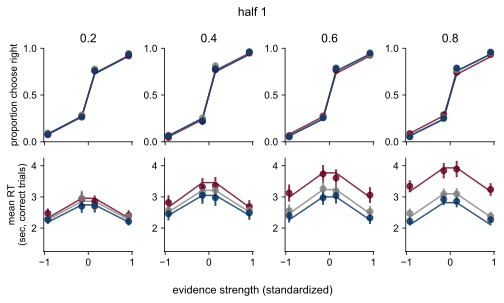

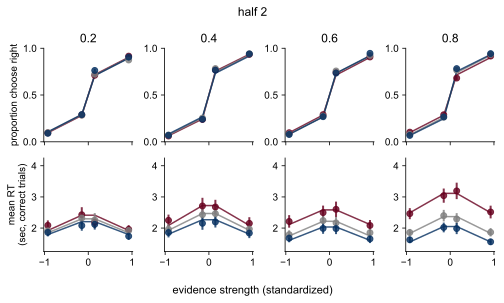

In [61]:
#horizontal version. 
cm = 1/2.54  # centimeters in inches

for h in half:

    fig,ax=plt.subplots(nrows=2,ncols=4)
    #then plot best fit model only against data separately per corr cond
    for axi,(rcp,dfp_r),(rcc,dfc_r) in zip(ax.T,datat_mhalf_psycho_ave_all.loc[h].groupby('rho_cond'),
                                   datat_mhalf_chrono_ave_all.loc[h].groupby('rho_cond')):
        assert rcp==rcc
        #print(rcp)
        dfp_r.reset_index(level='rho_cond',drop=True,inplace=True)
        dfc_r.reset_index(level='rho_cond',drop=True,inplace=True)
        plot_psycho_chrono_ave(dfp_r,dfc_r,mod_suffix='_best',
                                       alpha=0.8,RT_err=False,ax=axi,ax_labels=False)
        axi[0].set_ylim((0,1))
        axi[0].set_xticklabels([])
        axi[0].set_yticks([0,0.5,1])
        axi[0].set_title(rcp)
        axi[0].legend().set_visible(False)
        #axi[1].set_yticks([2,3])
        axi[1].set_xticks([-1.0,0.0,1.0])

        axi[1].locator_params(nbins=3, axis='y')
        axi[1].set_ylim((1.25,4.25))
        ##set_size(6,3,axi[0])
        ##set_size(6,3,axi[1])

    #     for axii in axi:
    #         axii.spines['top'].set_visible(False)
    #         axii.spines['right'].set_visible(False)

    fig.supxlabel('evidence strength (standardized)')
    ax[0,0].set_ylabel('proportion choose right')
    ax[1,0].set_ylabel('mean RT\n(sec, correct trials)')
    fig.suptitle('half %d' % h)
    fig.set_figwidth(18*cm)
    fig.set_figheight(21*cm/2)
    fig.tight_layout()

    print(fig.get_figwidth())
    print(fig.get_figheight())

## parameters

In [62]:
#Add column for best-fit params based on rho cond (as in model plots above)
if 'best' not in params_half.index.get_level_values('model'):
    params_half = params_half.copy()

    best_params_rlow = params_half.loc[idx[0.2:0.4,'bound_rscaleCLT_sk',:,:],:].rename(index={'bound_rscaleCLT_sk':'best'})
    best_params_rhigh = params_half.loc[idx[0.6:0.8,'bound_rscaleCLT_vk',:,:],:].rename(index={'bound_rscaleCLT_vk':'best'})

    display(best_params_rlow)
    display(best_params_rlow.index.get_level_values('rho_cond').unique())
    display(best_params_rlow.index.get_level_values('model').unique())

    display(best_params_rhigh)
    display(best_params_rhigh.index.get_level_values('rho_cond').unique())
    display(best_params_rhigh.index.get_level_values('model').unique())

    params_half = pd.concat([params_half,best_params_rlow,best_params_rhigh]).sort_index()

    display(params_half)

value  \
rho_cond model half subject                  param                     
0.2      best  1    5bd781291fd7c80001bb1fad B0             2.008700   
                                             Rn            -0.204771   
                                             Rp             0.069836   
                                             driftSNR0     26.270027   
                                             nondectime     0.738808   
...                                                              ...   
0.4      best  2    6172eebe85de20b0b268d5c5 Rp             0.282853   
                                             driftSNR0     22.526378   
                                             nondectime     0.415631   
                                             t              0.076749   
                                             umixturecoef   0.005720   

                                                          hit_boundary  
rho_cond model half subject                  param                      
0.2      best  1    5bd781291fd7c80001bb1fad B0                  False  
                                             Rn                  False  
                                             Rp                  False  
                                             driftSNR0           False  
                                             nondectime          False  
...                                                                ...  
0.4      best  2    6172eebe85de20b0b268d5c5 Rp                  False  
                                             driftSNR0           False  
                                             nondectime          False  
                                             t                   False  
                                             umixturecoef        False  

[700 rows x 2 columns]

Float64Index([0.2, 0.4], dtype='float64', name='rho_cond')

Index(['best'], dtype='object', name='model')

value  \
rho_cond model half subject                  param                     
0.6      best  1    5b232f6838fc0c000131438c B0             2.660993   
                                             Rn            -0.592863   
                                             Rp             0.796928   
                                             driftSNR0     13.839488   
                                             driftSNRn     14.758347   
...                                                              ...   
0.8      best  2    614fc66c9094c0a205c09a69 driftSNRn     12.838706   
                                             driftSNRp     25.437486   
                                             nondectime     0.614558   
                                             t              0.328012   
                                             umixturecoef   0.013044   

                                                          hit_boundary  
rho_cond model half subject                  param                      
0.6      best  1    5b232f6838fc0c000131438c B0                  False  
                                             Rn                  False  
                                             Rp                  False  
                                             driftSNR0           False  
                                             driftSNRn           False  
...                                                                ...  
0.8      best  2    614fc66c9094c0a205c09a69 driftSNRn           False  
                                             driftSNRp           False  
                                             nondectime          False  
                                             t                   False  
                                             umixturecoef        False  

[900 rows x 2 columns]

Float64Index([0.6, 0.8], dtype='float64', name='rho_cond')

Index(['best'], dtype='object', name='model')

value  \
rho_cond model              half subject                  param                     
0.2      best               1    5bd781291fd7c80001bb1fad B0             2.008700   
                                                          Rn            -0.204771   
                                                          Rp             0.069836   
                                                          driftSNR0     26.270027   
                                                          nondectime     0.738808   
...                                                                           ...   
0.8      bound_rscaleCLT_vk 2    614fc66c9094c0a205c09a69 driftSNRn     12.838706   
                                                          driftSNRp     25.437486   
                                                          nondectime     0.614558   
                                                          t              0.328012   
                                                          umixturecoef   0.013044   

                                                                       hit_boundary  
rho_cond model              half subject                  param                      
0.2      best               1    5bd781291fd7c80001bb1fad B0                  False  
                                                          Rn                  False  
                                                          Rp                  False  
                                                          driftSNR0           False  
                                                          nondectime          False  
...                                                                             ...  
0.8      bound_rscaleCLT_vk 2    614fc66c9094c0a205c09a69 driftSNRn           False  
                                                          driftSNRp           False  
                                                          nondectime          False  
                                                          t                   False  
                                                          umixturecoef        False  

[4800 rows x 2 columns]

In [63]:
#return to params and plot

params_half_ave = \
    params_half.drop(['hit_boundary'],axis=1).groupby(['model','rho_cond','half','param']).agg(['mean','std','sem'])
display(params_half_ave)

value                    
                                                    mean       std       sem
model              rho_cond half param                                      
best               0.2      1    B0             2.025110  0.643693  0.128739
                                 Rn            -0.123816  0.109576  0.021915
                                 Rp             0.138054  0.160897  0.032179
                                 driftSNR0     17.804167  3.811404  0.762281
                                 nondectime     0.418166  0.266507  0.053301
...                                                  ...       ...       ...
bound_rscaleCLT_vk 0.8      2    driftSNRn     15.279887  3.439397  0.687879
                                 driftSNRp     23.435026  5.025830  1.005166
                                 nondectime     0.333457  0.158588  0.031718
                                 t              0.120786  0.138242  0.027648
                                 umixturecoef   0.010144  0.011586  0.002317

[192 rows x 3 columns]

In [64]:
params_half

value  \
rho_cond model              half subject                  param                     
0.2      best               1    5bd781291fd7c80001bb1fad B0             2.008700   
                                                          Rn            -0.204771   
                                                          Rp             0.069836   
                                                          driftSNR0     26.270027   
                                                          nondectime     0.738808   
...                                                                           ...   
0.8      bound_rscaleCLT_vk 2    614fc66c9094c0a205c09a69 driftSNRn     12.838706   
                                                          driftSNRp     25.437486   
                                                          nondectime     0.614558   
                                                          t              0.328012   
                                                          umixturecoef   0.013044   

                                                                       hit_boundary  
rho_cond model              half subject                  param                      
0.2      best               1    5bd781291fd7c80001bb1fad B0                  False  
                                                          Rn                  False  
                                                          Rp                  False  
                                                          driftSNR0           False  
                                                          nondectime          False  
...                                                                             ...  
0.8      bound_rscaleCLT_vk 2    614fc66c9094c0a205c09a69 driftSNRn           False  
                                                          driftSNRp           False  
                                                          nondectime          False  
                                                          t                   False  
                                                          umixturecoef        False  

[4800 rows x 2 columns]

In [65]:
#compute scale dev for rho params and save params for analysis
rho_params_half_subj = params_half.loc[idx[:,'best',:,:,['Rn','Rp']],['value']].droplevel('model',axis=0).copy()
rho_params_half_subj['rho'] = rho_params_half_subj.index.get_level_values('rho_cond')
rho_params_half_subj['rho']*=2*(rho_params_half_subj.index.get_level_values('param')=='Rp')-1
rho_params_half_subj['scale_dev'] = np.sqrt(1+rho_params_half_subj['value'])/np.sqrt(1+rho_params_half_subj['rho'])

#save out rho params for analysis
if False:
    rho_params_half_subj.to_csv(path.join(data_dir,'rho_params_half_best_%s.csv' % date.today()),index=True)
    
#also save out all params for best model
if False:
    params_half.xs('best',level='model')[['value']].to_csv(path.join(data_dir,'params_half_best_%s.csv' % date.today()),index=True)